In [1]:
#!/usr/bin/env python3


MIRAGE-APP×ACT-2024 Dataset - Comprehensive Exploratory Data Analysis
=====================================================================

A production-ready script for analyzing temporal drift, protocol evolution,
and domain adaptation challenges in mobile app network traffic data.

Dataset: MIRAGE-APP×ACT-2024 (April 2021 - December 2023)
Author: Data Science Team
Date: 2025-12-13


==============================================================================



In [2]:
# IMPORTS AND CONFIGURATION


==============================================================================


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from collections import Counter
import warnings
from scipy import stats
from scipy.stats import gaussian_kde, ks_2samp, mannwhitneyu
from sklearn.preprocessing import StandardScaler
import re
from itertools import combinations
import argparse

# Parse command-line arguments
# parser = argparse.ArgumentParser(description='MIRAGE-APP×ACT-2024 Dataset - Exploratory Data Analysis')
# parser.add_argument('--sample', type=float, default=None,
#                     help='Sample fraction of dataset (e.g., 0.01 for 1%%). If not specified, uses full dataset.')
# parser.add_argument('--random-state', type=int, default=42,
#                     help='Random state for sampling (default: 42)')
# parser.add_argument('--sections', type=str, default='all',
#                     help='Sections to run. Options: "all" (default), comma-separated list (e.g., "0,1,2"), or range (e.g., "0-5")')
# args = parser.parse_args()


from dataclasses import dataclass
from typing import Optional

@dataclass
class args:
    sample: Optional[float] = None
    random_state: int = 42
    sections: str = 'all'


# Parse sections to run


In [4]:
def parse_sections(sections_arg):
    """Parse the sections argument and return a set of section numbers to run."""
    if sections_arg.lower() == 'all':
        return set(range(10))  # Sections 0-9

    sections_to_run = set()
    parts = sections_arg.split(',')

    for part in parts:
        part = part.strip()
        if '-' in part:
            # Range format: "0-5"
            try:
                start, end = map(int, part.split('-'))
                sections_to_run.update(range(start, end + 1))
            except ValueError:
                raise ValueError(f"Invalid range format: {part}. Use format like '0-5'")
        else:
            # Single section
            try:
                sections_to_run.add(int(part))
            except ValueError:
                raise ValueError(f"Invalid section number: {part}")

    # Validate section numbers
    valid_sections = set(range(10))
    invalid = sections_to_run - valid_sections
    if invalid:
        raise ValueError(f"Invalid section numbers: {sorted(invalid)}. Valid sections are 0-9.")

    return sections_to_run



In [5]:
sections_to_run = parse_sections(args.sections)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

# Paths
DATASET_PATH = Path('/home/anatbr/dataset/mirage/MIRAGE-AppAct-2024/parquet_files/')
OUTPUT_PATH = Path('./mirage_analysis_results')
OUTPUT_PATH.mkdir(exist_ok=True)

# Color palettes
TIME_COLORS = sns.color_palette('viridis', 10)



In [6]:
print("="*80)
print("MIRAGE-APP×ACT-2024 DATASET - EXPLORATORY DATA ANALYSIS")
print("="*80)


MIRAGE-APP×ACT-2024 DATASET - EXPLORATORY DATA ANALYSIS


In [7]:
if args.sample:
    print(f"Sampling: {args.sample*100:.1f}% of dataset (random_state={args.random_state})")
else:
    print("Sampling: DISABLED - using full dataset")
print(f"Sections to run: {sorted(sections_to_run) if sections_to_run != set(range(10)) else 'ALL (0-9)'}")
print(f"Output directory: {OUTPUT_PATH.absolute()}")
print(f"Dataset path: {DATASET_PATH.absolute()}")



Sampling: DISABLED - using full dataset
Sections to run: ALL (0-9)
Output directory: /home/anatbr/students/noamshakedc/da4etc/mirage_analysis_results
Dataset path: /home/anatbr/dataset/mirage/MIRAGE-AppAct-2024/parquet_files


==============================================================================



In [8]:
# SECTION 0: DATA LOADING AND PREPROCESSING


==============================================================================


In [9]:

if 0 in sections_to_run:
    print("\n" + "="*80)
    print("SECTION 0: DATA LOADING AND PREPROCESSING")



SECTION 0: DATA LOADING AND PREPROCESSING


# Load all columns except L4_raw_payload


In [10]:
    # Try to get available columns
    import pyarrow.parquet as pq
    pf = pq.ParquetDataset(str(DATASET_PATH))
    available_cols = pf.schema.names
    cols_to_load = [c for c in available_cols if c != "L4_raw_payload"]

    df = pd.read_parquet(
        str(DATASET_PATH),
        engine="pyarrow",
        columns=cols_to_load
    )

    # Apply sampling if requested
    if args.sample:
        print(f"Original dataset: {len(df):,} flows")
        df = df.sample(frac=args.sample, random_state=args.random_state)
        print(f"Sampled to: {len(df):,} flows ({args.sample*100:.1f}%)")
    else:
        print(f"Using full dataset: {len(df):,} flows")

    print(f"✓ Loaded {len(df):,} flows")
    print(f"  Columns: {len(df.columns)}")
    print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB")



Using full dataset: 106,157 flows
✓ Loaded 106,157 flows
  Columns: 39
  Memory usage: 0.27 GB


In [129]:
def map_activity_context(label: str) -> str:
    if not isinstance(label, str):
        return "unknown"

    l = label.lower()

    # normalize separators
    parts = set(l.replace(" ", "").split("-"))

    # precedence: videocall > audiocall > chat
    if "videocall" in parts:
        return "videocall_ctx"
    if "audiocall" in parts:
        return "audiocall_ctx"
    if "chat" in parts:
        return "chat_ctx"
    if "video-streaming" in l or "videoon-demand" in l:
        return "streaming_ctx"
    if "gaming" in l:
        return "gaming_ctx"

    return "unknown"


# apply
df["label"] = df["BF_activity"].apply(map_activity_context)

# optional but recommended
# df["is_composite"] = df["activity_label"].str.contains("-", na=False)

## #


In [134]:
from tqdm import tqdm

In [135]:
from pathlib import Path
import pandas as pd

base = Path("/home/anatbr/dataset/cesnet-quic22")
out_base = Path("cesnet-quic22_parquet")
out_base.mkdir(exist_ok=True)

flow_files = list(base.rglob("flows-*.csv.gz"))
chunksize = 1_000_000

for f in tqdm(flow_files):
    week = f.parts[-3]
    day  = f.parts[-2]
    date = f.stem.replace("flows-", "")

    out_dir = out_base / week / day
    out_dir.mkdir(parents=True, exist_ok=True)
    out_file = out_dir / f"flows-{date}.parquet"

    first = True
    for chunk in pd.read_csv(f, compression="gzip", chunksize=chunksize):
        chunk["week"], chunk["day"], chunk["date"] = week, day, date
  
        # write incrementally
        if first:
            chunk.to_parquet(out_file, index=False)
            first = False
        else:
            # append by concatenating parquet parts (simple approach: write multiple part files)
            part_file = out_dir / f"flows-{date}.part{len(list(out_dir.glob(f'flows-{date}.part*.parquet')))+1}.parquet"
            chunk.to_parquet(part_file, index=False)

print("Done converting to parquet parts.")


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [37:24<00:00, 80.16s/it]

Done converting to parquet parts.


In [12]:

    print("\nExtracting temporal features...")




Extracting temporal features...


In [13]:
# start timestamp as float (seconds since epoch)
df["capture_timestamp"] = df["timestamp"].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) and len(x) else np.nan)
df['capture_timestamp'] = pd.to_datetime(df["capture_timestamp"], unit="s", utc=True)

# Ensure capture_timestamp is datetime type


In [14]:
    df['capture_timestamp'] = pd.to_datetime(df['capture_timestamp'])

    # Create temporal features
    df['year'] = df['capture_timestamp'].dt.year
    df['month'] = df['capture_timestamp'].dt.month
    df['quarter'] = df['capture_timestamp'].dt.quarter
    df['year_month'] = df['capture_timestamp'].dt.to_period('M')
    df['year_quarter'] = df['capture_timestamp'].dt.to_period('Q')
    df['week'] = df['capture_timestamp'].dt.to_period('W')
    df['date'] = df['capture_timestamp'].dt.date

    print(f"✓ Temporal features extracted")
    print(f"  Date range: {df['capture_timestamp'].min()} to {df['capture_timestamp'].max()}")
    print(f"  Unique months: {df['year_month'].nunique()}")
    print(f"  Unique quarters: {df['year_quarter'].nunique()}")



✓ Temporal features extracted
  Date range: 2019-10-02 08:31:27.241782784+00:00 to 2023-12-14 15:32:08.252964864+00:00
  Unique months: 22
  Unique quarters: 10


## #



In [40]:

    print("\nComputing per-flow statistics from packet sequences...")




Computing per-flow statistics from packet sequences...


In [14]:
    def safe_stats(arr, stat_func, default=np.nan):
        """Safely compute statistics on arrays"""
        try:
            if isinstance(arr, (list, np.ndarray)) and len(arr) > 0:
                arr_clean = [x for x in arr if x is not None and not (isinstance(x, float) and np.isnan(x))]
                if len(arr_clean) > 0:
                    return stat_func(arr_clean)
        except:
            pass
        return default

    # Packet size statistics


In [15]:
    df['pkt_size_mean'] = df['IP_packet_bytes'].apply(lambda x: safe_stats(x, np.mean))
    df['pkt_size_median'] = df['IP_packet_bytes'].apply(lambda x: safe_stats(x, np.median))
    df['pkt_size_std'] = df['IP_packet_bytes'].apply(lambda x: safe_stats(x, np.std))
    df['pkt_size_min'] = df['IP_packet_bytes'].apply(lambda x: safe_stats(x, np.min))
    df['pkt_size_max'] = df['IP_packet_bytes'].apply(lambda x: safe_stats(x, np.max))

    # IAT statistics
    df['iat_mean'] = df['iat'].apply(lambda x: safe_stats(x, np.mean))
    df['iat_median'] = df['iat'].apply(lambda x: safe_stats(x, np.median))
    df['iat_std'] = df['iat'].apply(lambda x: safe_stats(x, np.std))



# TCP window size (only for TCP flows)


In [ ]:
    df['tcp_win_mean'] = df['TCP_win_size'].apply(lambda x: safe_stats(x, np.mean))

    print(f"✓ Per-flow statistics computed")



## #



In [ ]:
    # Derived features


## #


In [117]:

    print("\nComputing derived features...")

    # Avoid division by zero
    df['bytes_per_second'] = np.where(
        df['BF_duration'] > 0,
        df['BF_IP_packet_bytes'] / df['empirical_duration'],
        np.nan
    )

    df['packets_per_second'] = np.where(
        df['BF_duration'] > 0,
        df['BF_num_packets'] / df['empirical_duration'],
        np.nan
    )

    df['avg_pkt_size'] = np.where(
        df['BF_num_packets'] > 0,
        df['BF_IP_packet_bytes'] / df['BF_num_packets'],
        np.nan
    )

    df['up_down_bytes_ratio'] = np.where(
        df['DF_IP_packet_bytes'] > 0,
        df['UF_IP_packet_bytes'] / df['DF_IP_packet_bytes'],
        np.nan
    )

    df['up_down_pkts_ratio'] = np.where(
        df['DF_num_packets'] > 0,
        df['UF_num_packets'] / df['DF_num_packets'],
        np.nan
    )

    print(f"✓ Derived features computed")




Computing derived features...
✓ Derived features computed


## #



In [31]:
    # Protocol detection heuristic


## #


In [ ]:

    print("\nDetecting protocols...")



In [ ]:
    def get_most_common_port(port_list):
        """Get most common destination port from list"""
        try:
            if isinstance(port_list, (list, np.ndarray)) and len(port_list) > 0:
                return Counter(port_list).most_common(1)[0][0]
        except:
            pass
        return None



In [ ]:
    df['dst_port_main'] = df['dst_port'].apply(get_most_common_port)



In [ ]:
    def detect_protocol(row):
        """Detect protocol based on TCP flags and destination port"""
        # Check if TCP or UDP
        tcp_flags = row.get('TCP_flags', [])
        is_tcp = isinstance(tcp_flags, (list, np.ndarray)) and len(tcp_flags) > 0

        port = row.get('dst_port_main')

        if is_tcp:
            if port == 443:
                return 'TCP:TLS'
            elif port == 80:
                return 'TCP:HTTP'
            elif port == 1935:
                return 'TCP:RTMPT'
            elif port == 3478:
                return 'TCP:STUN'
            else:
                return 'TCP:OTHER'
        else:  # UDP
            if port == 443:
                return 'UDP:QUIC'
            elif port in [3478, 19302]:
                return 'UDP:STUN'
            elif port in [5004, 5005]:
                return 'UDP:RTCP'
            else:
                return 'UDP:OTHER'

        df['protocol'] = df.apply(detect_protocol, axis=1)

        print(f"✓ Protocol detection complete")
        print(f"  Protocol distribution:")
        for proto, count in df['protocol'].value_counts().head(10).items():
            print(f"    {proto}: {count:,} ({count/len(df)*100:.1f}%)")

        print(f"\n✓ Preprocessing complete - {len(df):,} flows ready for analysis")


In [ ]:
else:
    print("\n⊘ SECTION 0: SKIPPED (not in selected sections)")


# Still need to load data if any other section is selected


In [ ]:
    if len(sections_to_run) > 0:
        print("  Note: Loading minimal dataset for subsequent sections...")


# Load minimal data needed for other sections


In [ ]:
        all_cols_query = ['BF_IP_packet_bytes', 'BF_L4_payload_bytes', 'BF_activity', 'BF_device',
            'BF_duration', 'BF_label', 'BF_label_source', 'BF_label_version_code',
            'BF_label_version_name', 'BF_labeling_type', 'BF_num_packets', 'BF_sublabel',
            'DF_IP_packet_bytes', 'DF_L4_payload_bytes', 'DF_MSS', 'DF_WS',
            'DF_duration', 'DF_num_packets',
            'UF_IP_packet_bytes', 'UF_L4_payload_bytes', 'UF_MSS', 'UF_WS',
            'UF_duration', 'UF_num_packets',
            'path', 'timestamp', 'dst_port', 'src_port', 'packet_dir',
            'IP_packet_bytes', 'L4_payload_bytes', 'iat', 'TCP_flags', 'TCP_win_size',
            'IP_header_bytes', 'L4_header_bytes', 'L4_payload_bytes', 'annotations',
            'heuristic', 'is_clear']
        df = pd.read_parquet(DATASET_PATH, columns=all_cols_query)
        if args.sample:
            df = df.sample(frac=args.sample, random_state=args.random_state).reset_index(drop=True)
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        df['year_month'] = df['timestamp'].dt.to_period('M')
        df['year_quarter'] = df['timestamp'].dt.to_period('Q')
        df['year'] = df['timestamp'].dt.year
        df['month'] = df['timestamp'].dt.month



==============================================================================



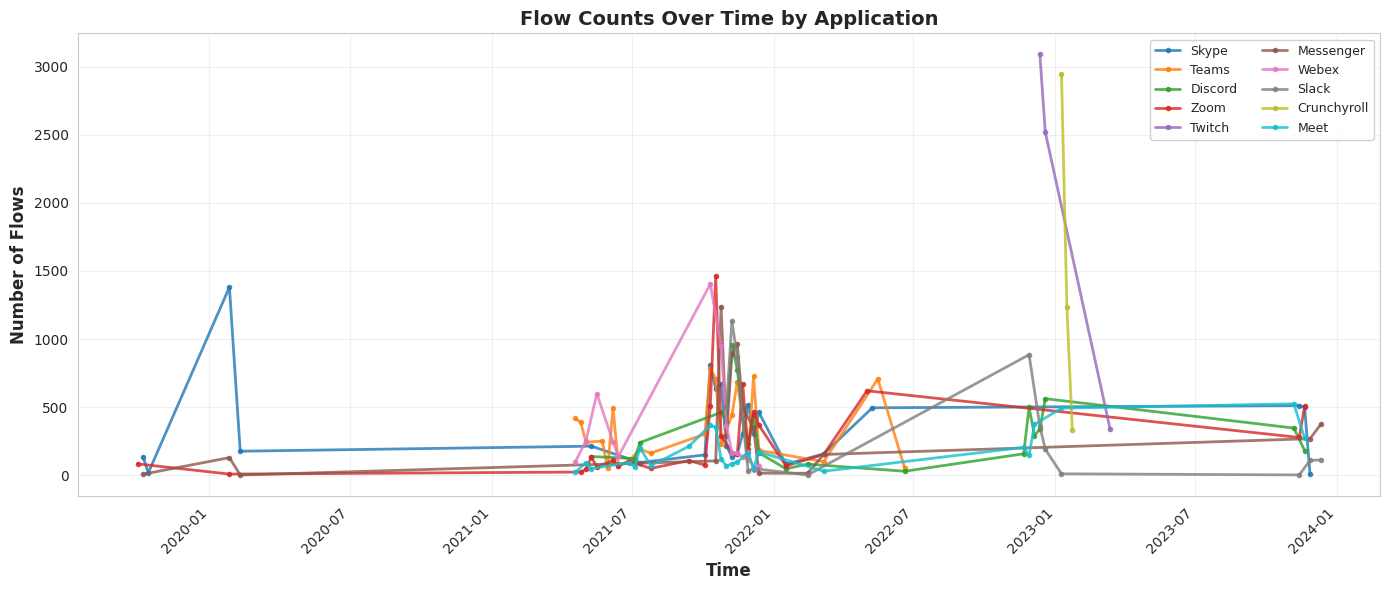

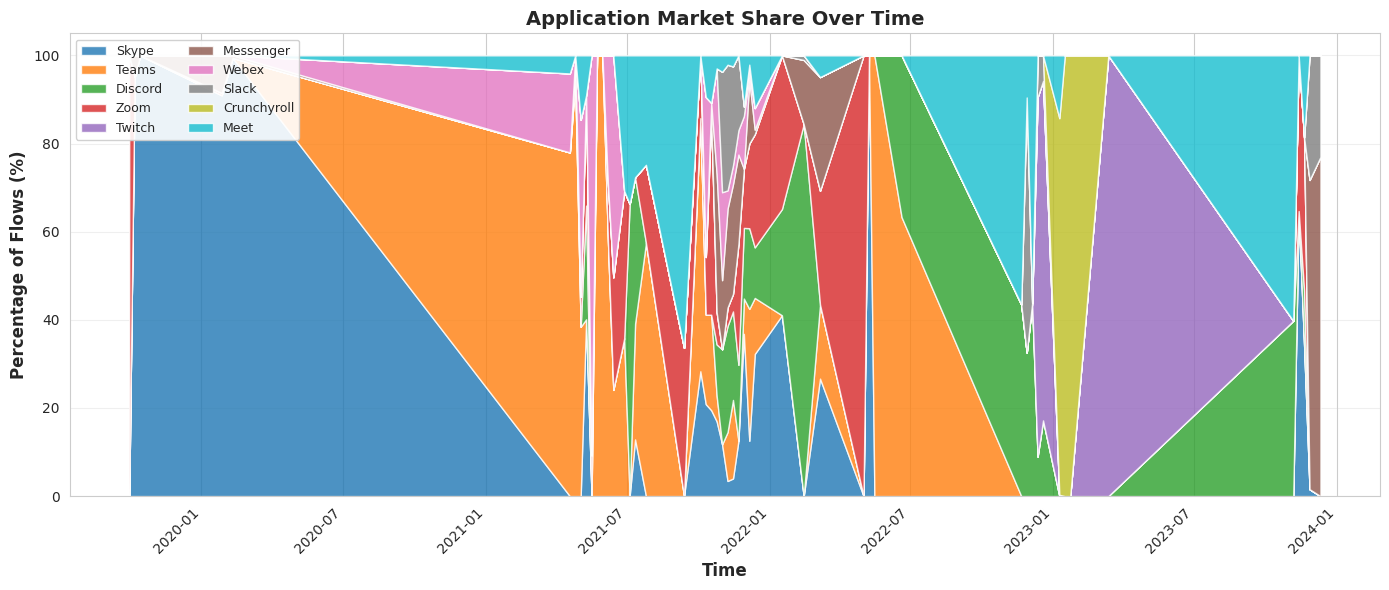

In [247]:
apps = ["Skype", "Teams", "Discord", "Zoom", "Twitch", "Messenger", "Webex", "Slack", "Crunchyroll", "Meet"]

# 1a. Flow counts over time (weekly/monthly)
app_data = df[df.BF_label.isin(apps)].copy()
app_data['week'] = pd.to_datetime(app_data['capture_timestamp']).dt.to_period('W')

fig, ax = plt.subplots(figsize=(14, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(apps)))

for i, app in enumerate(apps):
    weekly_counts = app_data[app_data.BF_label == app].groupby('week').size()
    ax.plot(weekly_counts.index.to_timestamp(), weekly_counts.values, 
            marker='o', markersize=3, linewidth=2, label=app, color=colors[i], alpha=0.8)

ax.set_xlabel('Time', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Flows', fontsize=12, fontweight='bold')
ax.set_title('Flow Counts Over Time by Application', fontsize=14, fontweight='bold')
ax.legend(fontsize=9, loc='best', ncol=2, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'apps_flow_counts_over_time.png', dpi=150, bbox_inches='tight')
plt.show()

# 1b. Market share over time (percentage stacked area)
weekly_pivot = app_data.groupby(['week', 'BF_label']).size().unstack(fill_value=0)
weekly_pct = weekly_pivot.div(weekly_pivot.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(14, 6))
ax.stackplot(weekly_pct.index.to_timestamp(), 
             *[weekly_pct[app].values for app in apps if app in weekly_pct.columns],
             labels=[app for app in apps if app in weekly_pct.columns], alpha=0.8)
ax.set_xlabel('Time', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage of Flows (%)', fontsize=12, fontweight='bold')
ax.set_title('Application Market Share Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=9, loc='upper left', ncol=2, framealpha=0.9)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(OUTPUT_PATH / '0_apps_market_share_over_time.png', dpi=150, bbox_inches='tight')
plt.show()

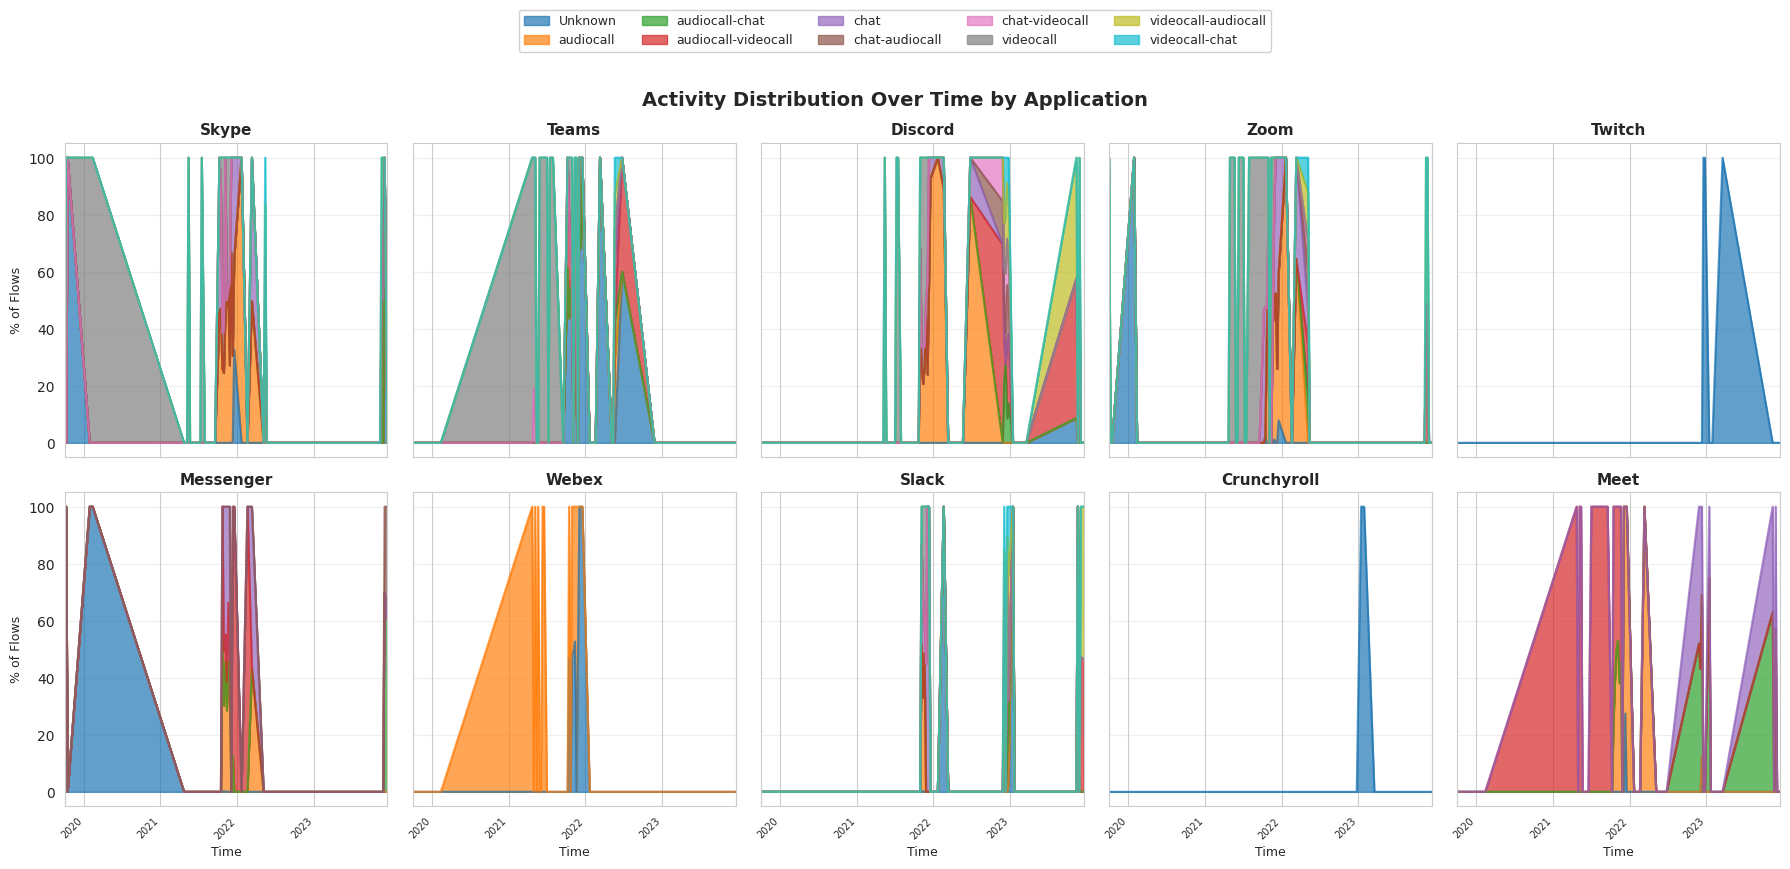

In [252]:
# 3. Activity breakdown by app over time (shared time axis)

# Make a global, sorted week axis
all_weeks = np.sort(app_data["week"].unique())

fig, axes = plt.subplots(2, 5, figsize=(18, 8), sharey=True, sharex=True)
axes = axes.flatten()

for i, app in enumerate(apps):
    ax = axes[i]
    app_subset = app_data[app_data.BF_label == app]

    if len(app_subset) > 0:
        activity_time = (
            app_subset.groupby(["week", "BF_activity"])
            .size()
            .unstack(fill_value=0)
        )

        # Force every app to have the exact same week axis (fill missing weeks with 0)
        activity_time = activity_time.reindex(all_weeks, fill_value=0)

        activity_time_pct = activity_time.div(activity_time.sum(axis=1), axis=0).fillna(0) * 100

        activity_time_pct.plot(kind="area", stacked=True, ax=ax, alpha=0.7, legend=False)

    ax.set_title(app, fontsize=11, fontweight="bold")
    ax.set_xlabel("Time", fontsize=9)
    if i % 5 == 0:
        ax.set_ylabel("% of Flows", fontsize=9)

    ax.grid(True, alpha=0.3, axis="y")

    # Force identical x-limits for all
    ax.set_xlim(all_weeks[0], all_weeks[-1])

    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", fontsize=7)

# Add common legend (only if there is at least one plotted axis)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 1.02),
           ncol=5, fontsize=9, framealpha=0.9)

plt.suptitle("Activity Distribution Over Time by Application", fontsize=14, fontweight="bold", y=0.98)
plt.tight_layout()
plt.savefig(OUTPUT_PATH / '0_activity_per_app_over_time.png', dpi=150, bbox_inches='tight')
plt.show()


In [255]:
df.columns

Index(['BF_IP_packet_bytes', 'BF_L4_payload_bytes', 'BF_activity', 'BF_device',
       'BF_duration', 'BF_label', 'BF_label_source', 'BF_label_version_code',
       'BF_label_version_name', 'BF_labeling_type', 'BF_num_packets',
       'BF_sublabel', 'DF_IP_packet_bytes', 'DF_L4_payload_bytes', 'DF_MSS',
       'DF_WS', 'DF_duration', 'DF_num_packets', 'IP_header_bytes',
       'IP_packet_bytes', 'L4_header_bytes', 'L4_payload_bytes', 'TCP_flags',
       'TCP_win_size', 'UF_IP_packet_bytes', 'UF_L4_payload_bytes', 'UF_MSS',
       'UF_WS', 'UF_duration', 'UF_num_packets', 'annotations', 'dst_port',
       'heuristic', 'iat', 'is_clear', 'packet_dir', 'path', 'src_port',
       'timestamp', 'capture_timestamp', 'year', 'month', 'quarter',
       'year_month', 'year_quarter', 'week', 'date', 'pkt_size_mean',
       'pkt_size_median', 'pkt_size_std', 'pkt_size_min', 'pkt_size_max',
       'iat_mean', 'iat_median', 'iat_std', 'bytes_per_second',
       'packets_per_second', 'avg_pkt_size', 

In [258]:
df[classification_features].isna().mean()

empirical_duration     0.000000
BF_num_packets         0.000000
bytes_per_second       0.008393
packets_per_second     0.008393
avg_pkt_size           0.000000
iat_mean               0.000000
up_down_bytes_ratio    0.053817
up_down_pkts_ratio     0.053817
dtype: float64

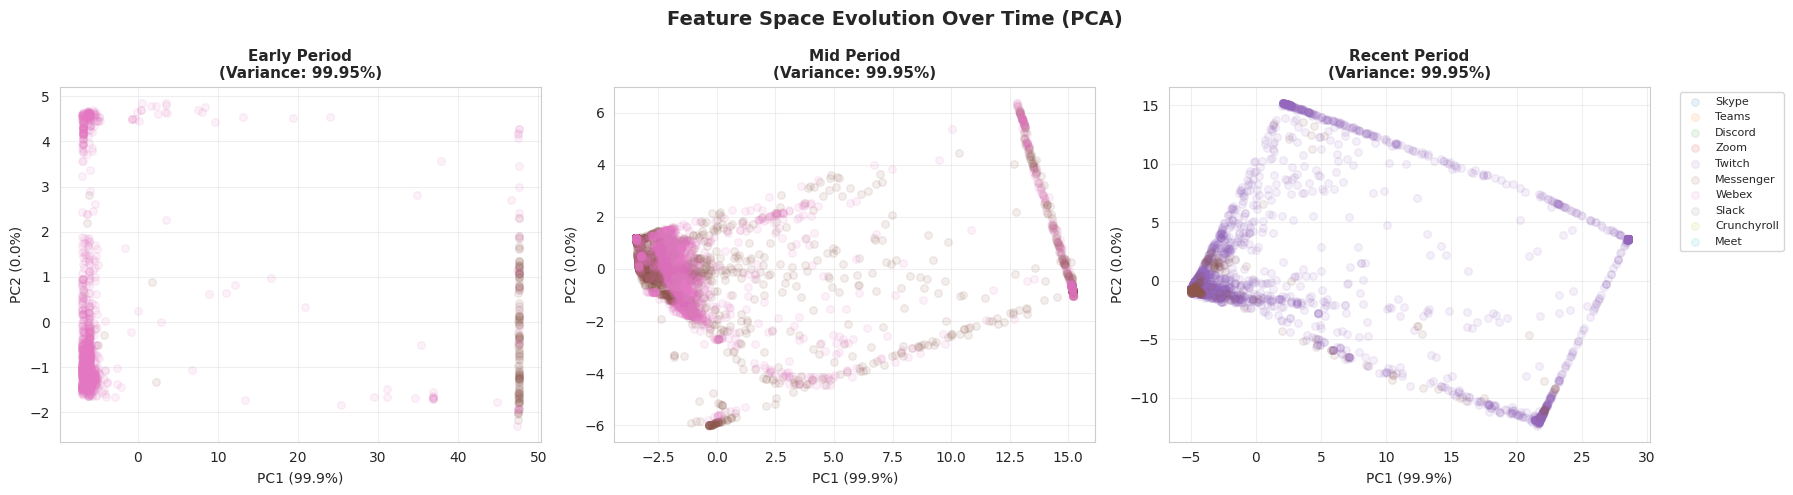

In [279]:
# 6. Feature space visualization over time periods
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
import numpy as np

# Select numerical features for classification
classification_features = [
    'empirical_duration', 'BF_num_packets', 'bytes_per_second',
    'packets_per_second', 'avg_pkt_size', 'iat_mean',
    # 'up_down_bytes_ratio', 'up_down_pkts_ratio'
]

# Split into time periods
app_subset = df[df.BF_label.isin(apps[4:7])].copy().dropna()
app_subset['period'] = pd.cut(
    app_subset['year_quarter'].rank(method='dense'),
    bins=3, labels=['Early', 'Mid', 'Recent']
)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, period in enumerate(['Early', 'Mid', 'Recent']):
    ax = axes[idx]
    period_data = app_subset[app_subset['period'] == period]

    # Sample for visualization
    sample_data = period_data

    # -------- CLEANING STEP --------
    X = sample_data[classification_features].copy()
    X = X.apply(pd.to_numeric, errors='coerce')

    # Drop rows with inf / -inf
    inf_mask = np.isinf(X).any(axis=1)
    X = X.loc[~inf_mask]

    # Drop rows with NaN
    X = X.dropna()

    # Keep labels aligned
    sample_data = sample_data.loc[X.index]
    # --------------------------------
    # 1) Clip extreme values per feature (winsorize)
    lo = X.quantile(0.1)
    hi = X.quantile(0.9)
    X = X.clip(lower=lo, upper=hi, axis=1)
    
    # 2) Robust scale
    X_scaled = RobustScaler().fit_transform(X)
    
    # 3) PCA
    X_pca = PCA(n_components=2).fit_transform(X_scaled)

    # Plot by app
    for i, app in enumerate(apps):
        mask = sample_data.BF_label == app
        ax.scatter(
            X_pca[mask, 0], X_pca[mask, 1],
            c=[colors[i]], label=app, alpha=0.1, s=30
        )

    ax.set_title(
        f'{period} Period\n(Variance: {pca.explained_variance_ratio_.sum():.2%})',
        fontsize=11, fontweight='bold'
    )
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=10)
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=10)
    ax.grid(True, alpha=0.3)

    if idx == 2:
        ax.legend(fontsize=8, loc='best', bbox_to_anchor=(1.05, 1))

plt.suptitle('Feature Space Evolution Over Time (PCA)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
# SECTION 1: TEMPORAL COVERAGE & SESSION DISTRIBUTION


==============================================================================


In [ ]:

if 1 in sections_to_run:
    print("\n" + "="*80)
    print("SECTION 1: TEMPORAL COVERAGE & SESSION DISTRIBUTION")


In [ ]:
    print("="*80)



KeyError: 'BF_IP_packet_count'

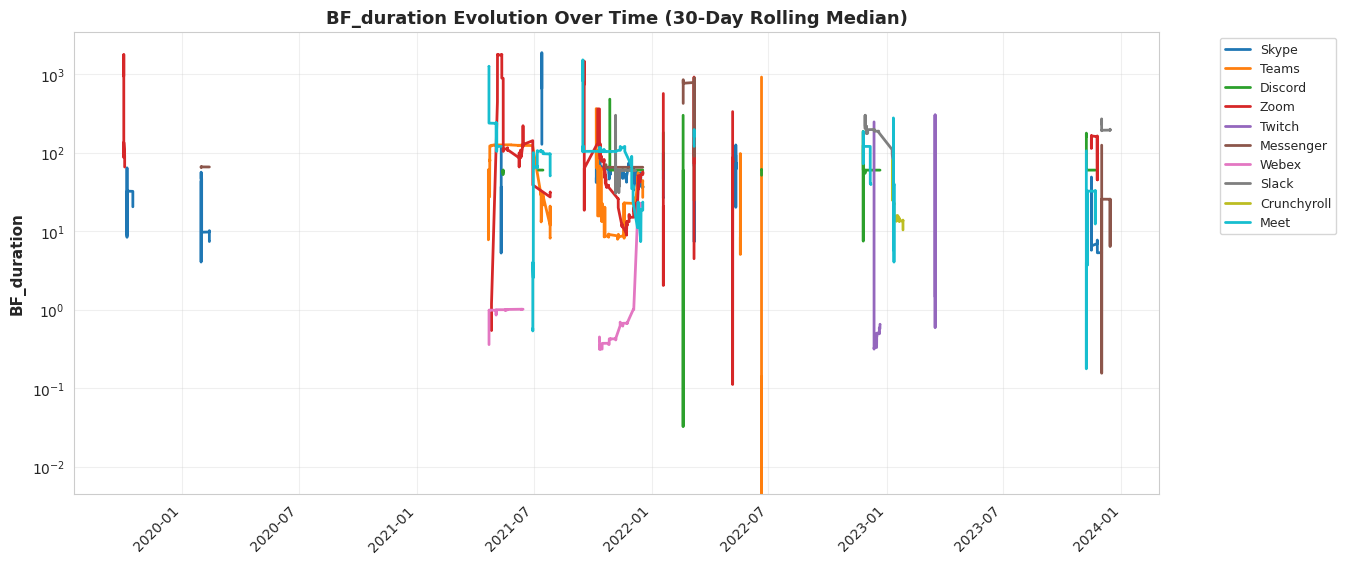

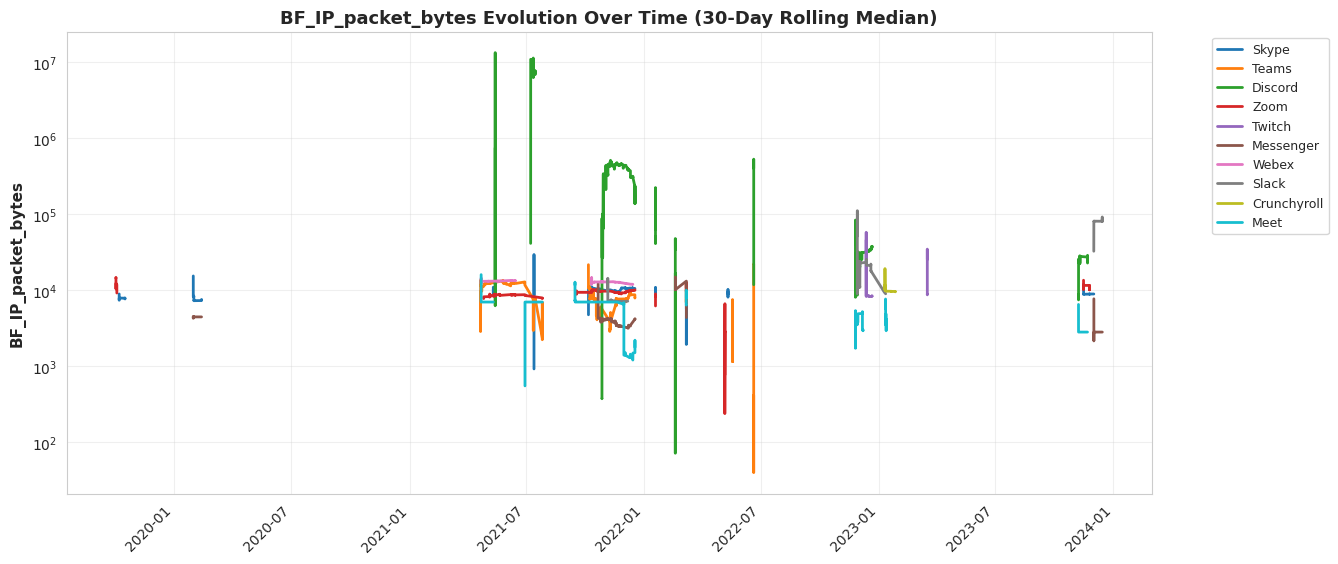

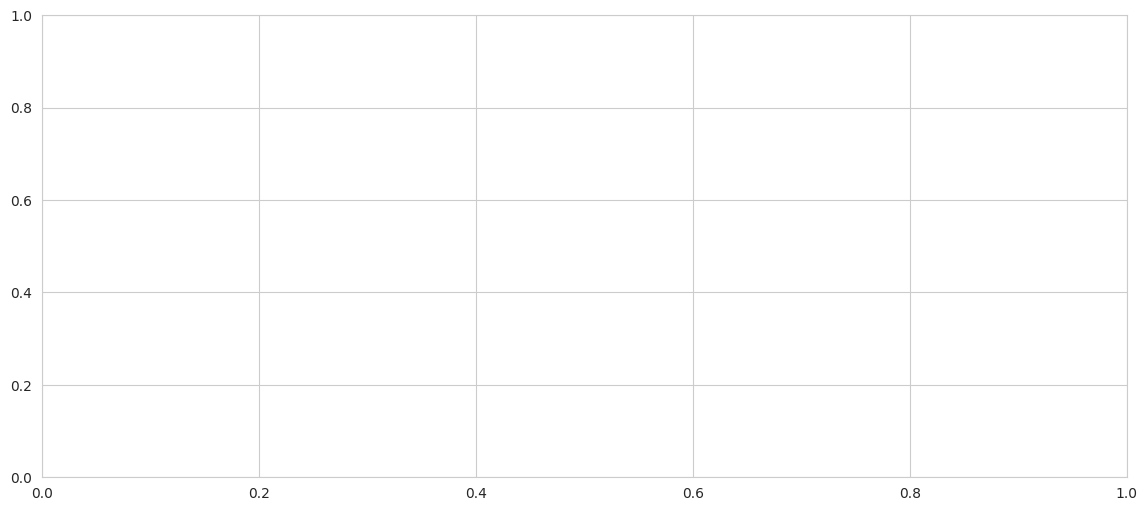

In [243]:
apps = ["Skype", "Teams", "Discord", "Zoom", "Twitch", "Messenger", "Webex", "Slack", "Crunchyroll", "Meet"]

# Key features for classification
key_features = ['BF_duration', 'BF_IP_packet_bytes', 'BF_IP_packet_count', 
                'BF_bytes_rate', 'BF_packet_rate']

for feature in key_features:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    for app in apps:
        app_data = df[(df.BF_label == app) & (df[feature].notna())].copy()
        app_data = app_data.sort_values('capture_timestamp').set_index('capture_timestamp')
        
        # Rolling median
        rolling_median = app_data[feature].rolling(window='30D', min_periods=10).median()
        ax.plot(rolling_median.index, rolling_median.values, linewidth=2, label=app)
    
    ax.set_yscale('log')
    ax.set_ylabel(feature, fontsize=11, fontweight='bold')
    ax.set_title(f'{feature} Evolution Over Time (30-Day Rolling Median)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
    # plt.savefig(OUTPUT_PATH / f'classification_{feature}_over_time.png', dpi=150, bbox_inches='tight')
    # plt.show()

In [242]:
df.BF_label.value_counts()

BF_label
/system/bin/netd                           22681
Skype                                       8120
Teams                                       7397
Discord                                     6867
Zoom                                        6749
Twitch                                      5949
Messenger                                   5280
Webex                                       4789
Slack                                       4655
Crunchyroll                                 4517
Meet                                        4305
GotoMeeting                                 3873
Telegram                                    3800
Trueconf                                    3296
Background                                  2942
Omlet                                       2426
Signal                                      1916
JitsiMeet                                   1459
Line                                        1202
WhatsApp                                     919
com.android

In [28]:

# extract fields
sizes = np.array(audio_video_flow.L4_payload_bytes)
dirs  = np.array(audio_video_flow.packet_dir)
iat   = np.array(audio_video_flow.iat)

In [29]:
sizes.max() , sizes.min()

(1400, 0)

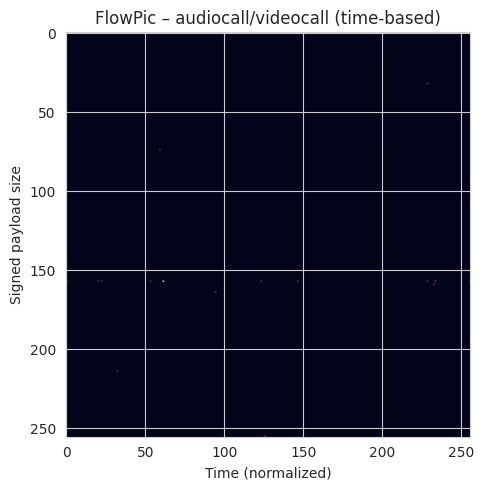

In [32]:
# --- SAFE extraction (works even if attribute access collides) ---
sizes = np.asarray(audio_video_flow["L4_payload_bytes"], dtype=float).ravel()
dirs  = np.asarray(audio_video_flow["packet_dir"], dtype=int).ravel()
iat   = np.asarray(audio_video_flow["iat"], dtype=float).ravel()

# handle empty / degenerate cases
n = min(len(sizes), len(dirs), len(iat))
sizes, dirs, iat = sizes[:n], dirs[:n], iat[:n]

# signed payload sizes (1 = outgoing, 0 = incoming)
signed_sizes = np.where(dirs == 1, sizes, -sizes)

# optional clipping (recommended)
signed_sizes = np.clip(signed_sizes, -1500, 1500)

# x-axis: cumulative time
t = np.cumsum(iat)

# avoid divide-by-zero if all iat are 0
tmax = t.max() if t.size and t.max() > 0 else 1.0
smin, smax = signed_sizes.min(), signed_sizes.max()
den = (smax - smin) if (smax - smin) != 0 else 1.0

# flowpic resolution
H, W = 256, 256
img = np.zeros((H, W), dtype=np.float32)

# normalize to image grid
t_norm = np.clip((t / tmax * (W - 1)).astype(int), 0, W - 1)
y_norm = np.clip(((signed_sizes - smin) / den * (H - 1)).astype(int), 0, H - 1)

# rasterize (density)
for xi, yi in zip(t_norm, y_norm):
    img[H - 1 - yi, xi] += 1.0  # flip y for image coordinates

# visualize
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title("FlowPic – audiocall/videocall (time-based)")
plt.xlabel("Time (normalized)")
plt.ylabel("Signed payload size")
plt.tight_layout()
plt.show()


In [19]:
df['duration'] = df['iat'].apply(np.sum)

In [31]:
df = df[df.duration.between(60*1, 60*20) ]

In [32]:
(df.duration > 60 *20).mean()

0.0

<Axes: >

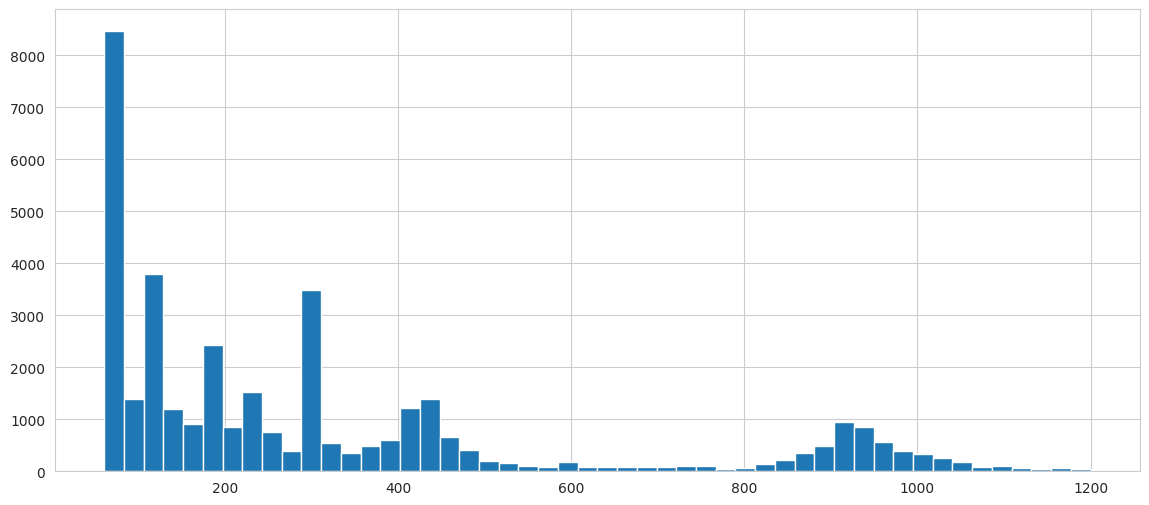

In [33]:
df.duration.hist(bins=50)

In [44]:
df.BF_activity.value_counts()

BF_activity
videocall              9471
audiocall              6364
video-streaming        4602
chat                   3548
audiocall-videocall    2907
videocall-audiocall    2460
Unknown                2323
chat-videocall         1059
chat-audiocall         1029
audiocall-chat          933
videocall-chat          854
gaming-online            75
video on-demand          46
Name: count, dtype: int64

In [117]:
for idss, row in (df.groupby(['BF_activity', 'BF_label']).count()).iterrows():
    print(idss, row['year'])

('Unknown', 'Background') 1793
('Unknown', 'Discord') 19
('Unknown', 'Line') 1
('Unknown', 'Meet') 17
('Unknown', 'Messenger') 119
('Unknown', 'Playstore') 206
('Unknown', 'Signal') 27
('Unknown', 'Skype') 61
('Unknown', 'Slack') 11
('Unknown', 'Telegram') 1
('Unknown', 'Trueconf') 7
('Unknown', 'Workplace') 32
('Unknown', 'Zoom') 29
('audiocall', 'Discord') 1029
('audiocall', 'GotoMeeting') 622
('audiocall', 'Meet') 371
('audiocall', 'Messenger') 920
('audiocall', 'Skype') 853
('audiocall', 'Slack') 625
('audiocall', 'Teams') 956
('audiocall', 'Telegram') 103
('audiocall', 'Webex') 272
('audiocall', 'Zoom') 613
('audiocall-chat', 'Discord') 140
('audiocall-chat', 'Line') 47
('audiocall-chat', 'Signal') 181
('audiocall-chat', 'Skype') 43
('audiocall-chat', 'Slack') 162
('audiocall-chat', 'Teams') 65
('audiocall-chat', 'Telegram') 115
('audiocall-chat', 'Trueconf') 93
('audiocall-chat', 'WhatsApp') 27
('audiocall-chat', 'Zoom') 60
('audiocall-videocall', 'Discord') 385
('audiocall-video

Telegram


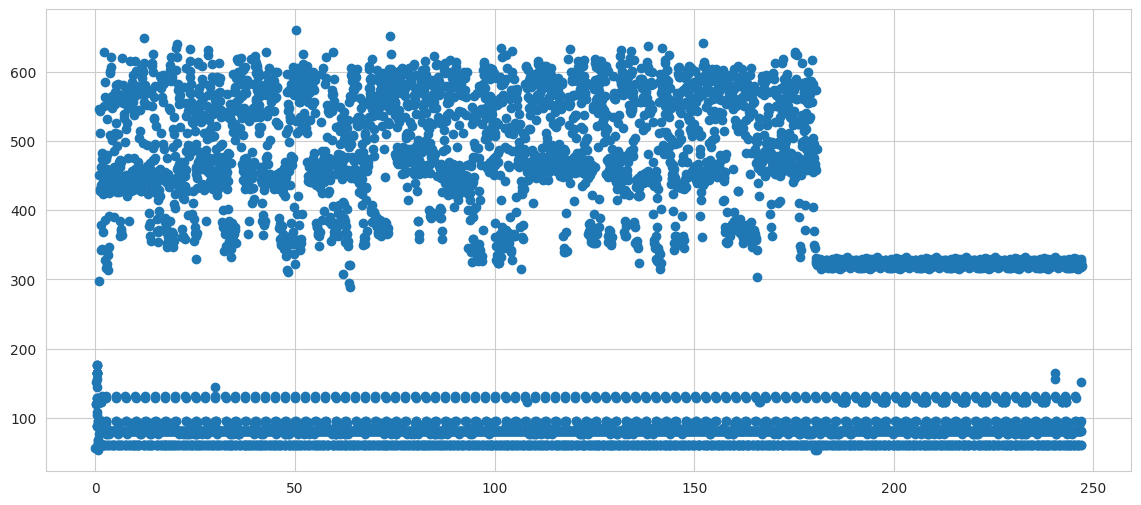

In [105]:
i +=1 
audio_video_flow = df[(df.duration > 3*60) & (df.BF_activity == 'audiocall-chat') & (df.BF_label == 'Telegram')].iloc[i]

# --- SAFE extraction (works even if attribute access collides) ---
sizes = np.asarray(audio_video_flow["IP_packet_bytes"], dtype=float).ravel()
dirs  = np.asarray(audio_video_flow["packet_dir"], dtype=int).ravel()
iat   = np.asarray(audio_video_flow["iat"], dtype=float).ravel()
print(audio_video_flow.BF_label)
plt.scatter(np.cumsum(iat), sizes)

In [126]:
df.iloc[0]

BF_IP_packet_bytes                                                 1111896
BF_L4_payload_bytes                                                1018764
BF_activity                                                  gaming-online
BF_device                                                1e:65:95:7e:34:0b
BF_duration                                                     423.736357
BF_label                                                       ClashRoyale
BF_label_source                                                    netstat
BF_label_version_code                                                  555
BF_label_version_name                                             3.3074.2
BF_labeling_type                                                     exact
BF_num_packets                                                        1791
BF_sublabel                                      com.supercell.clashroyale
DF_IP_packet_bytes                                                 1054263
DF_L4_payload_bytes      

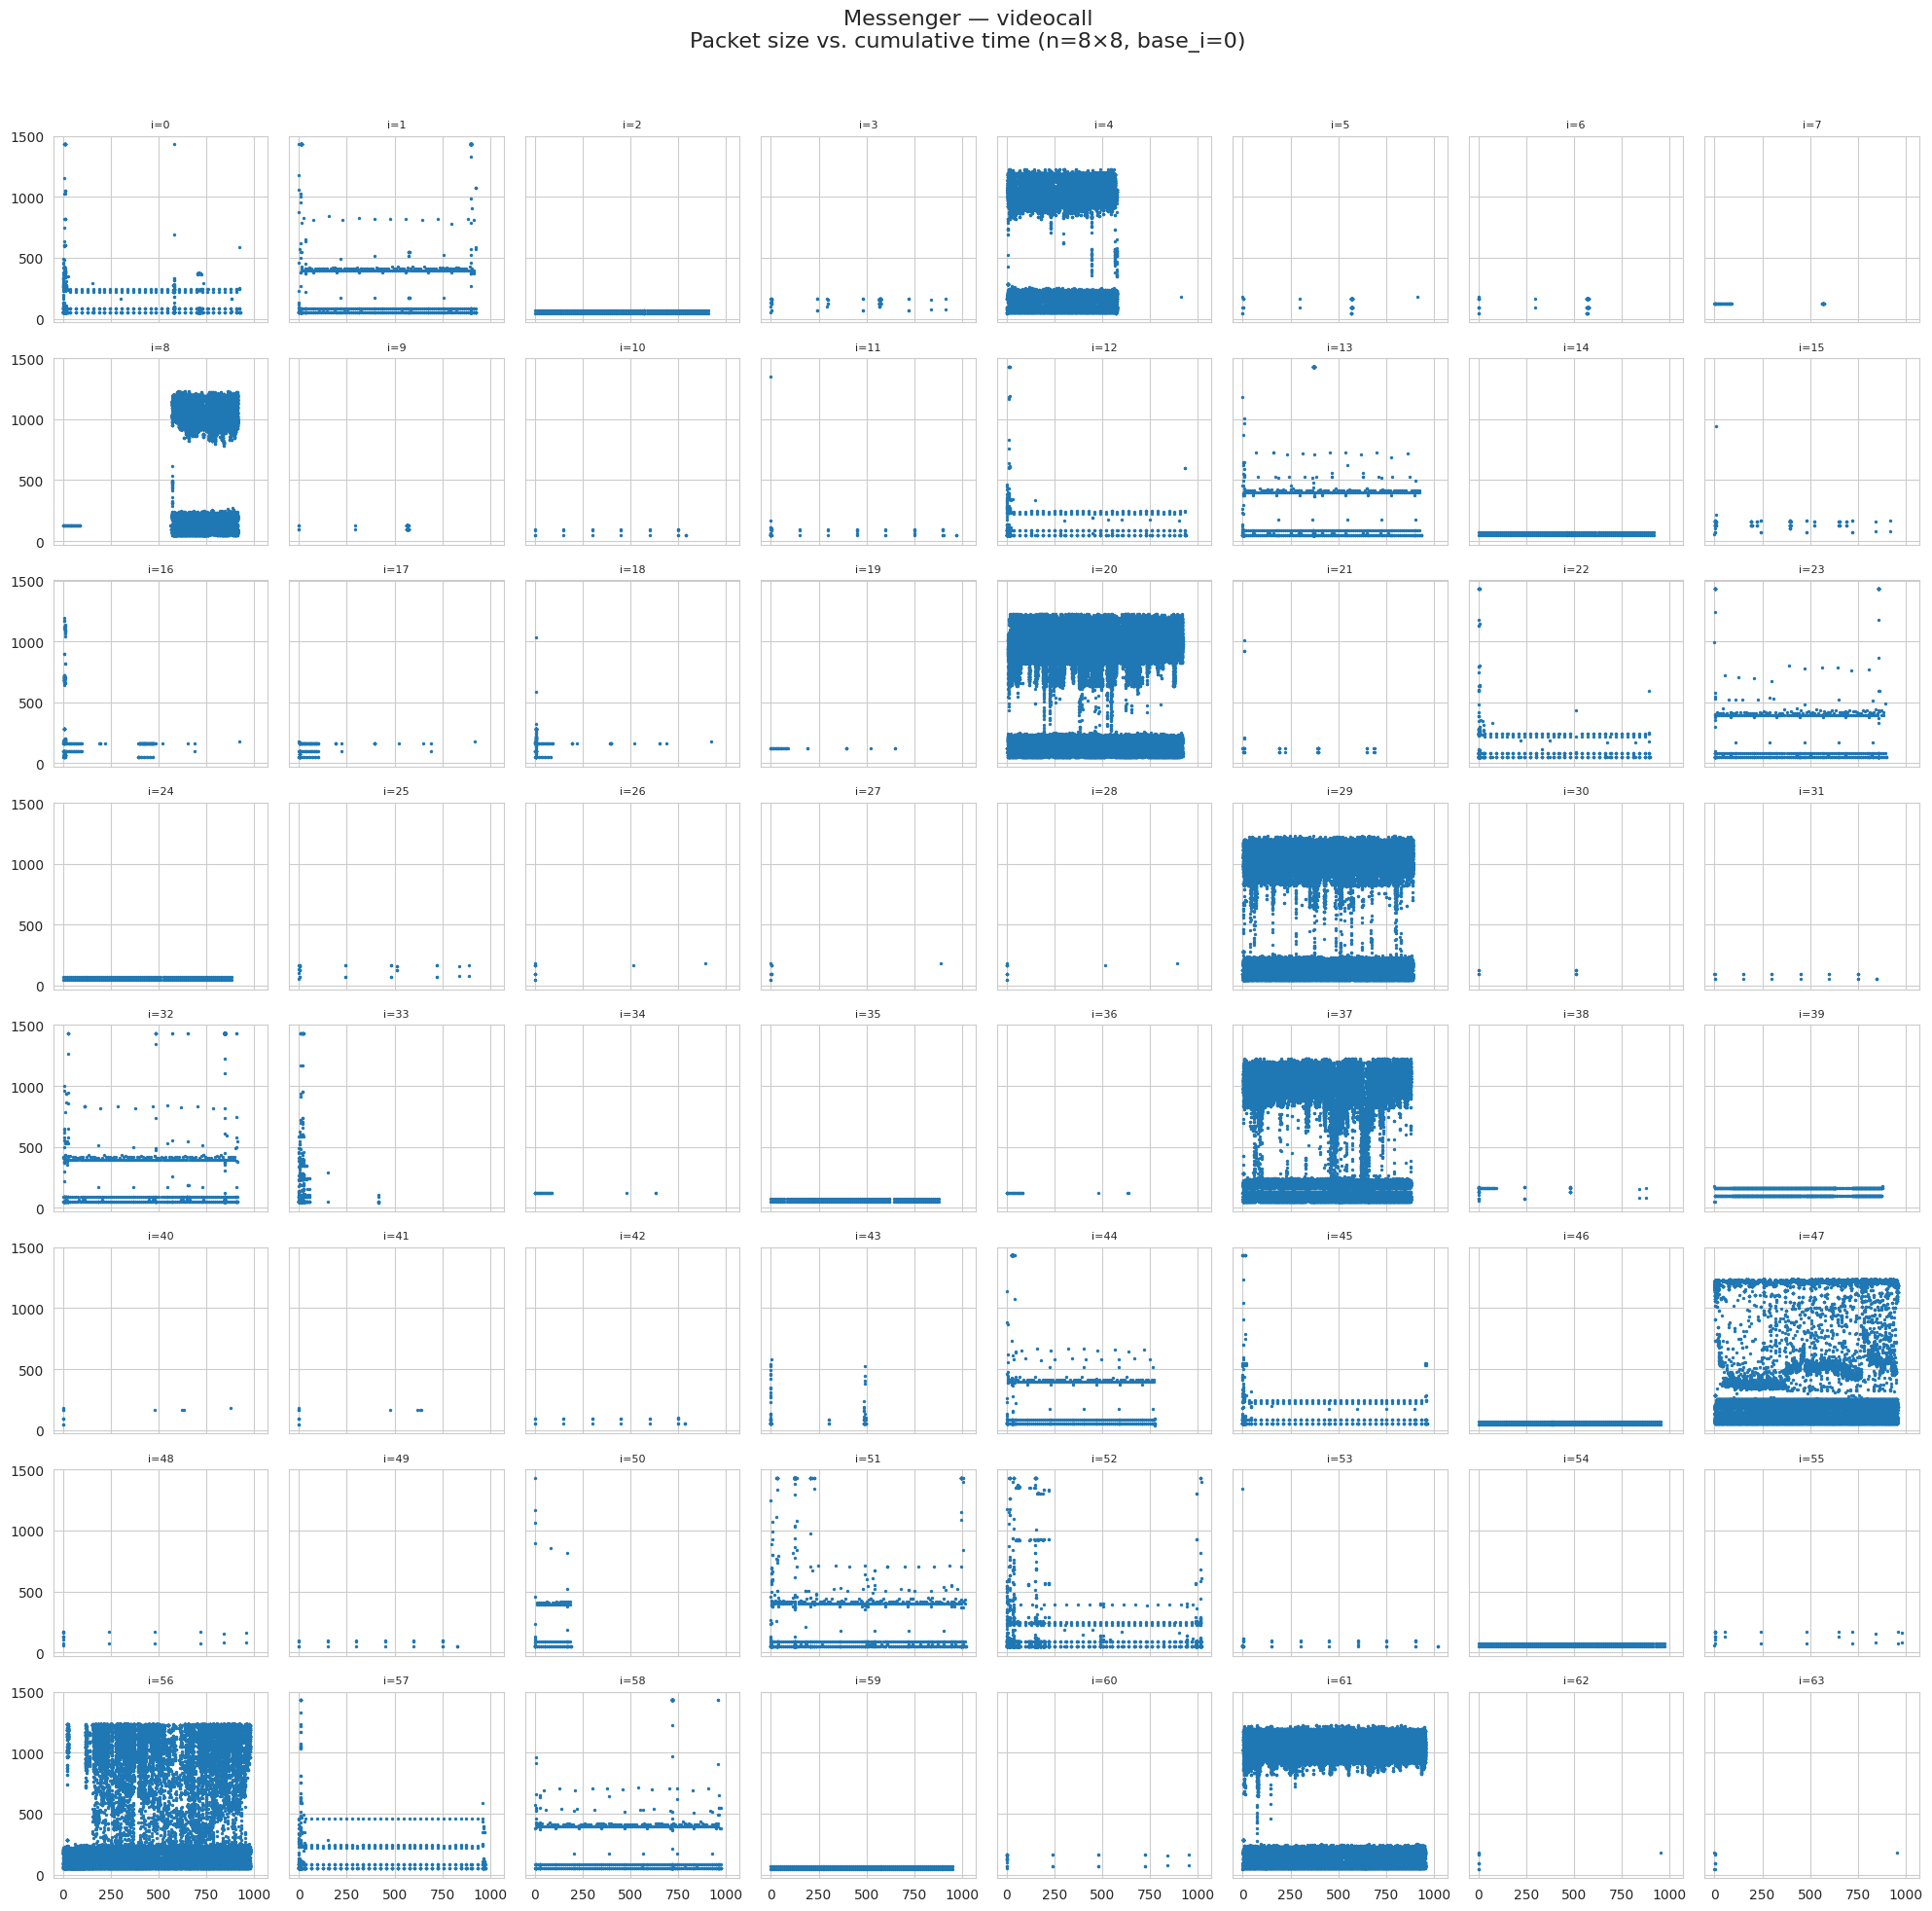

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- config ----------
n = 8
figsize = (20, 20)
base_i = 0

app = "Messenger"
activity = "videocall"
min_duration_s = 3 * 60

title = "{app} — {activity}\nPacket size vs. cumulative time (n={n}×{n}, base_i={base_i})"
title_kwargs = dict(fontsize=16)

save_fig = True
out_dir = Path('mirage_analysis_results')
fname = "{app}_{activity}_grid_base{base_i}.png"
dpi = 300
# ----------------------------

subset = df[
    (df.duration > min_duration_s) &
    (df.BF_activity == activity) &
    (df.BF_label == app)
]

fig, axes = plt.subplots(n, n, figsize=figsize, sharex=True, sharey=True)

fig.suptitle(
    title.format(app=app, activity=activity, n=n, base_i=base_i),
    **title_kwargs
)

for idx, ax in enumerate(axes.flat):
    j = base_i + idx
    if j >= len(subset):
        ax.axis("off")
        continue

    row = subset.iloc[j]
    sizes = np.asarray(row["IP_packet_bytes"], dtype=float).ravel()
    iat   = np.asarray(row["iat"], dtype=float).ravel()

    ax.scatter(np.cumsum(iat), sizes, s=2)
    ax.set_title(f"i={j}", fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.96])

# ---------- save ----------
if save_fig:
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / fname.format(
        app=app,
        activity=activity,
        base_i=base_i
    )
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
# --------------------------

plt.show()


In [16]:
'videocall',  'audiocall-videocall', 'videocall-audiocall'
'audiocall',
'video-streaming',
'chat', 'Unknown', 'chat-audiocall',
       'chat-videocall', 'audiocall-chat', 'videocall-chat', 'gaming-online',
       'video on-demand'

Index(['videocall', 'audiocall', 'video-streaming', 'audiocall-videocall',
       'chat', 'videocall-audiocall', 'Unknown', 'chat-audiocall',
       'chat-videocall', 'audiocall-chat', 'videocall-chat', 'gaming-online',
       'video on-demand'],
      dtype='object', name='BF_activity')

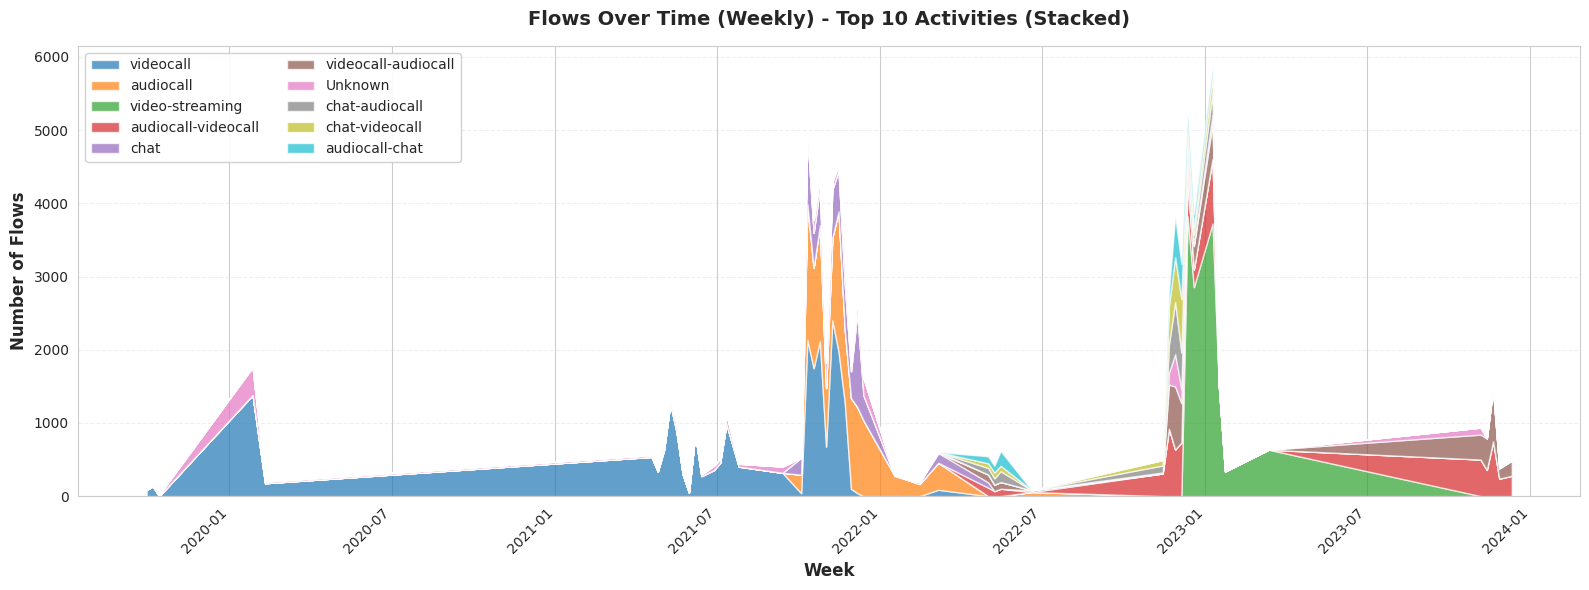

In [42]:
# Get top 10 activities
top_activities = df.BF_activity.value_counts().iloc[:10].index

# Create weekly bins
df_temp = df.copy()
df_temp['week'] = pd.to_datetime(df_temp['capture_timestamp']).dt.to_period('W')

# Create pivot table: weeks x activities
weekly_pivot = df_temp[df_temp.BF_activity.isin(top_activities)].groupby(['week', 'BF_activity']).size().unstack(fill_value=0)

# Create the plot
plt.figure(figsize=(16, 6))

# Convert period index to timestamp
x = weekly_pivot.index.to_timestamp()

# Stacked area chart
plt.stackplot(x, *[weekly_pivot[activity].values for activity in top_activities],
              labels=top_activities, alpha=0.7)

plt.xlabel('Week', fontsize=12, fontweight='bold')
plt.ylabel('Number of Flows', fontsize=12, fontweight='bold')
plt.title(f'Flows Over Time (Weekly) - Top {len(top_activities)} Activities (Stacked)', fontsize=14, fontweight='bold', pad=15)
plt.legend(fontsize=10, loc='upper left', ncol=2, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--', axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(OUTPUT_PATH / '1.1c_flows_over_time_weekly_top10_activities_stacked.png',
            dpi=150, bbox_inches='tight')
plt.show()

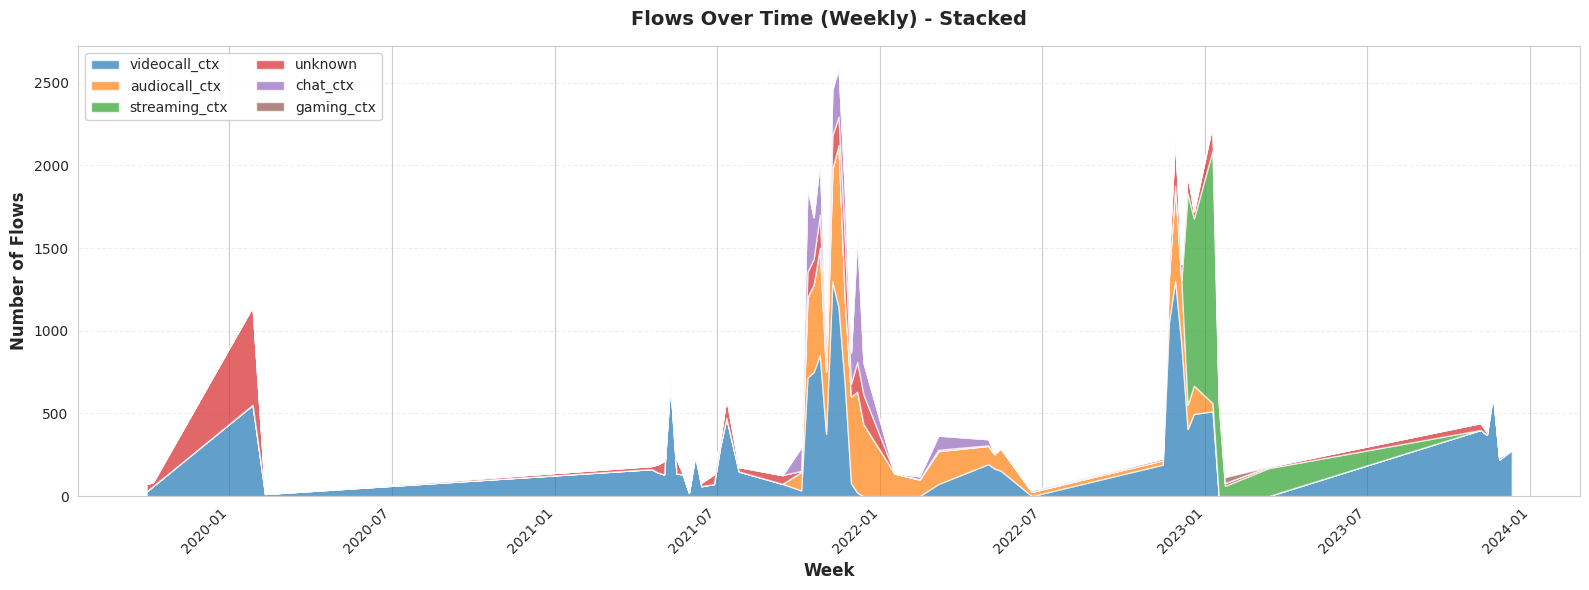

In [132]:
# --- choose what you're plotting ---
# If you want activities, use label_ctx (recommended from earlier)
LABEL_COL = "label"   # or "BF_activity" or "label" depending on your df
TIME_COL  = "capture_timestamp"

df_temp = df.copy()

# Ensure timestamp is datetime
df_temp[TIME_COL] = pd.to_datetime(df_temp[TIME_COL], errors="coerce")
df_temp = df_temp.dropna(subset=[TIME_COL, LABEL_COL])

# Weekly bins (week ending Sunday by default). If you want Monday-start weeks: 'W-MON'
df_temp["week"] = df_temp[TIME_COL].dt.to_period("W")

# Pick top labels (top 10 by count)
top_labels = df_temp[LABEL_COL].value_counts().head(10).index.tolist()

# Pivot: weeks x labels
weekly_pivot = (
    df_temp.groupby(["week", LABEL_COL])
          .size()
          .unstack(fill_value=0)
          .sort_index()
)

# Make sure we only use columns that exist (robust)
top_labels = [lab for lab in top_labels if lab in weekly_pivot.columns]

# If nothing left, fail loudly and clearly
if not top_labels:
    raise ValueError("No labels found to plot. Check LABEL_COL or filtering.")

# Convert PeriodIndex to timestamps for plotting
x = weekly_pivot.index.to_timestamp()

# Prepare y-values in consistent order
ys = [weekly_pivot[lab].to_numpy() for lab in top_labels]

plt.figure(figsize=(16, 6))
plt.stackplot(x, *ys, labels=top_labels, alpha=0.7)

plt.xlabel("Week", fontsize=12, fontweight="bold")
plt.ylabel("Number of Flows", fontsize=12, fontweight="bold")
plt.title("Flows Over Time (Weekly) - Stacked", fontsize=14, fontweight="bold", pad=15)

plt.legend(fontsize=10, loc="upper left", ncol=2, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle="--", axis="y")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.savefig(OUTPUT_PATH / "1.1b_over_time_weekly_stacked.png", dpi=150, bbox_inches="tight")
plt.show()


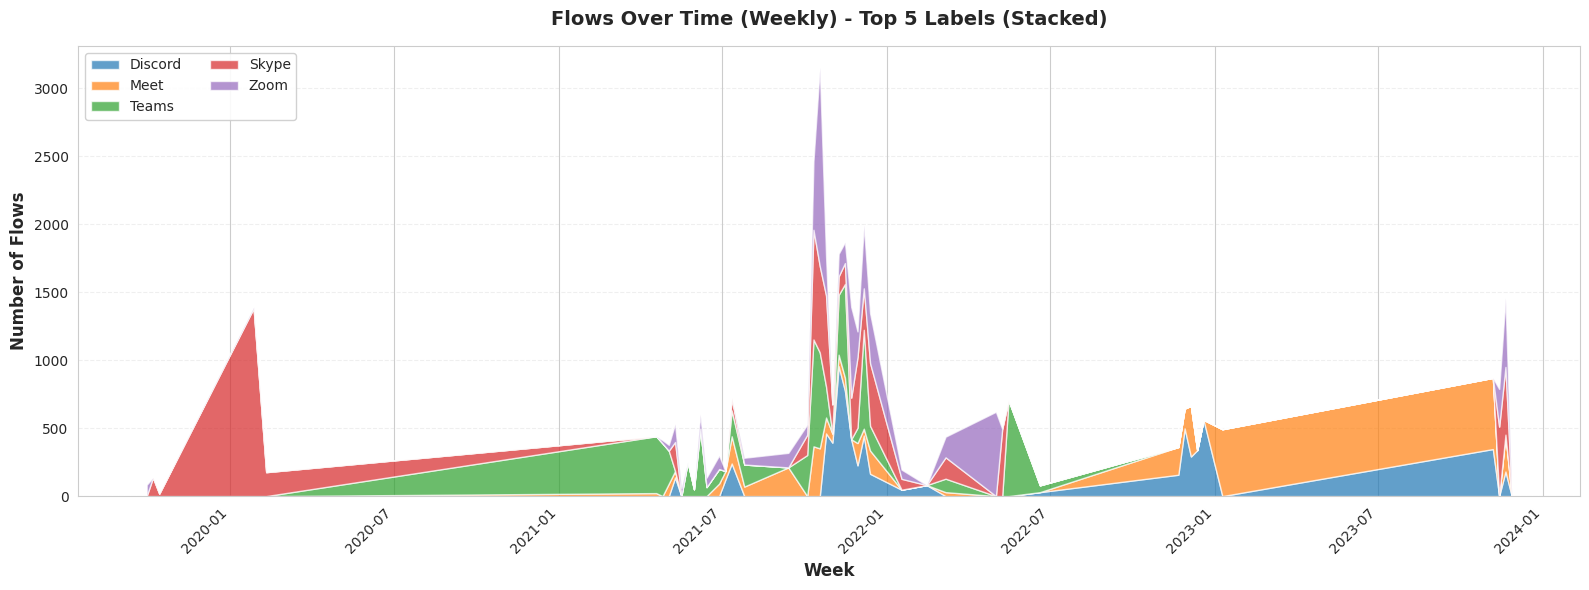

In [282]:
# Get top 10 labels
# top_labels = df.BF_label.value_counts().iloc[1:11].index
top_labels = ['Discord', 'Meet', 'Teams', 'Skype', 'Zoom']

# Create weekly bins
df_temp = df.copy()
df_temp['week'] = pd.to_datetime(df_temp['capture_timestamp']).dt.to_period('W')

# Create pivot table: weeks x labels
weekly_pivot = df_temp[df_temp.BF_label.isin(top_labels)].groupby(['week', 'BF_label']).size().unstack(fill_value=0)

# Create the plot
plt.figure(figsize=(16, 6))

# Convert period index to timestamp
x = weekly_pivot.index.to_timestamp()

# Stacked area chart
plt.stackplot(x, *[weekly_pivot[label].values for label in top_labels],
              labels=top_labels, alpha=0.7)

plt.xlabel('Week', fontsize=12, fontweight='bold')
plt.ylabel('Number of Flows', fontsize=12, fontweight='bold')
plt.title(f'Flows Over Time (Weekly) - Top {len(top_labels)} Labels (Stacked)', fontsize=14, fontweight='bold', pad=15)
plt.legend(fontsize=10, loc='upper left', ncol=2, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--', axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig(OUTPUT_PATH / '1.1b_flows_over_time_weekly_top10_labels_stacked.png',
            dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
    # 1.1a: Sessions per month
    print("\n[1.1a] Plotting sessions per month...")
    sessions_per_month = df.groupby('year_month')['path'].nunique().reset_index()
    sessions_per_month.columns = ['year_month', 'session_count']
    sessions_per_month['year_month_str'] = sessions_per_month['year_month'].astype(str)

    plt.figure(figsize=(14, 5))
    plt.plot(range(len(sessions_per_month)), sessions_per_month['session_count'],
             marker='o', linewidth=2, markersize=6, color='steelblue')
    plt.xlabel('Time Period')
    plt.ylabel('Number of Capture Sessions')
    plt.title('1.1a: Capture Sessions Over Time (Monthly)')
    plt.xticks(range(len(sessions_per_month)), sessions_per_month['year_month_str'], rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '1.1a_sessions_per_month.png', dpi=150, bbox_inches='tight')
    plt.close()

    # 1.1b: Flows per week
    print("[1.1b] Plotting flows per week...")
    flows_per_week = df.groupby('week').size().reset_index()
    flows_per_week.columns = ['week', 'flow_count']
    flows_per_week['week_str'] = flows_per_week['week'].astype(str)

    plt.figure(figsize=(16, 5))
    plt.plot(range(len(flows_per_week)), flows_per_week['flow_count'],
             linewidth=1.5, color='darkgreen', alpha=0.7)
    plt.xlabel('Week')
    plt.ylabel('Number of Flows')
    plt.title('1.1b: Flows Over Time (Weekly)')
    plt.xticks(range(0, len(flows_per_week), max(1, len(flows_per_week)//20)),
               flows_per_week['week_str'].iloc[::max(1, len(flows_per_week)//20)],
               rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '1.1b_flows_per_week.png', dpi=150, bbox_inches='tight')
    plt.close()



# 1.2: Heatmap - Sessions by app × time


In [ ]:
    print("[1.2] Creating sessions by app × time heatmap...")
    sessions_app_time = df.groupby(['BF_label', 'year_month'])['path'].nunique().reset_index()
    sessions_pivot = sessions_app_time.pivot(index='BF_label', columns='year_month', values='path').fillna(0)

    plt.figure(figsize=(16, 8))
    sns.heatmap(sessions_pivot, cmap='YlOrRd', annot=False, fmt='.0f',
                linewidths=0.5, cbar_kws={'label': 'Session Count'})
    plt.xlabel('Time Period (Monthly)')
    plt.ylabel('App Name')
    plt.title('1.2: Capture Sessions by App and Time Period (Monthly)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '1.2_sessions_app_time_heatmap.png', dpi=150, bbox_inches='tight')
    plt.close()



# 1.3: Daily capture activity timeline


In [ ]:
    print("[1.3] Creating daily activity timeline...")
    flows_per_day = df.groupby('date').size().reset_index()
    flows_per_day.columns = ['date', 'flow_count']

    # Create full date range
    date_range = pd.date_range(df['date'].min(), df['date'].max(), freq='D')
    full_days = pd.DataFrame({'date': date_range.date})
    daily_activity = full_days.merge(flows_per_day, on='date', how='left').fillna(0)
    daily_activity['is_gap'] = daily_activity['flow_count'] == 0

    gap_pct = (daily_activity['is_gap'].sum() / len(daily_activity)) * 100
    active_pct = 100 - gap_pct

    plt.figure(figsize=(16, 6))
    colors = ['red' if gap else 'steelblue' for gap in daily_activity['is_gap']]
    plt.bar(range(len(daily_activity)), daily_activity['flow_count'] + 1, color=colors, width=1.0, alpha=0.7)
    plt.yscale('log')
    plt.xlabel('Date')
    plt.ylabel('Flow Count (log scale)')
    plt.title(f'1.3: Daily Capture Activity Timeline (Red = Gap Days)\nActive: {active_pct:.1f}% | Gaps: {gap_pct:.1f}%')
    plt.xticks(range(0, len(daily_activity), max(1, len(daily_activity)//15)),
               [str(d) for d in daily_activity['date'].iloc[::max(1, len(daily_activity)//15)]],
               rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '1.3_daily_activity_timeline.png', dpi=150, bbox_inches='tight')
    plt.close()

    print(f"  Active days: {active_pct:.1f}% | Gap days: {gap_pct:.1f}%")



# 1.4: Stacked area chart - App distribution over time


In [ ]:
    print("[1.4] Creating app distribution stacked area chart...")
    app_dist_time = df.groupby(['year_month', 'BF_label']).size().reset_index()
    app_dist_time.columns = ['year_month', 'BF_label', 'count']
    app_dist_pivot = app_dist_time.pivot(index='year_month', columns='BF_label', values='count').fillna(0)
    app_dist_norm = app_dist_pivot.div(app_dist_pivot.sum(axis=1), axis=0)

    plt.figure(figsize=(14, 6))
    app_dist_norm.plot.area(stacked=True, colormap='tab20', ax=plt.gca(), linewidth=0)
    plt.xlabel('Time Period (Monthly)')
    plt.ylabel('Proportion of Flows')
    plt.title('1.4: App Distribution Over Time (Relative Proportions)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '1.4_app_distribution_stacked_area.png', dpi=150, bbox_inches='tight')
    plt.close()



# 1.5: App version updates timeline


In [ ]:
    print("[1.5] Creating app version updates timeline...")
    version_timeline = df.groupby(['BF_label', 'year_month', 'BF_label_version_code']).size().reset_index()
    version_timeline = version_timeline.drop_duplicates(subset=['BF_label', 'year_month', 'BF_label_version_code'])

    apps = df['BF_label'].unique()
    app_to_idx = {app: idx for idx, app in enumerate(apps)}

    plt.figure(figsize=(14, max(6, len(apps) * 0.3)))
    for _, row in version_timeline.iterrows():
        app_idx = app_to_idx[row['BF_label']]
        month_str = str(row['year_month'])
        plt.scatter(month_str, app_idx, color='steelblue', s=30, alpha=0.6)

    plt.yticks(range(len(apps)), apps, fontsize=8)
    plt.xlabel('Time Period (Monthly)')
    plt.ylabel('App Name')
    plt.title('1.5: App Version Updates Timeline (Each dot = new version)')
    xticks_idx = range(0, len(version_timeline['year_month'].unique()), max(1, len(version_timeline['year_month'].unique())//15))
    xticks_labels = [str(m) for i, m in enumerate(version_timeline['year_month'].unique()) if i in xticks_idx]
    plt.xticks(xticks_labels, rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '1.5_app_version_timeline.png', dpi=150, bbox_inches='tight')
    plt.close()



# 1.6: App version summary table


In [ ]:
    print("[1.6] Creating app version summary...")
    version_summary = df.groupby('BF_label').agg({
        'BF_label_version_code': 'nunique',
        'path': 'size'
    }).reset_index()
    version_summary.columns = ['App', 'Num_Versions', 'Total_Flows']
    version_summary = version_summary.sort_values('Num_Versions', ascending=False)

    print("\nApp Version Summary (Top 10):")
    print(version_summary.head(10).to_string(index=False))



# Print detailed version timeline for first 5 apps


In [ ]:
    print("\nDetailed Version Timeline (Top 5 Apps by Version Count):")
    for app in version_summary.head(5)['App']:
        app_versions = df[df['BF_label'] == app].groupby(['year_month', 'BF_label_version_code']).size().reset_index()
        app_versions.columns = ['year_month', 'version', 'flow_count']
        print(f"\n{app}:")
        for _, row in app_versions.head(10).iterrows():
            print(f"  {row['year_month']}: {row['version']} ({row['flow_count']} flows)")

    print("\n✓ Section 1 complete - visualizations saved")
else:
    print("\n⊘ SECTION 1: SKIPPED (not in selected sections)")



==============================================================================



In [ ]:
# SECTION 2: PROTOCOL EVOLUTION ANALYSIS


==============================================================================


In [ ]:

if 2 in sections_to_run:
    print("\n" + "="*80)
    print("SECTION 2: PROTOCOL EVOLUTION ANALYSIS")


In [ ]:
    print("="*80)



In [ ]:
    # 2.1: Stacked bar chart - Protocol distribution by quarter
    print("\n[2.1] Creating protocol distribution stacked bar chart...")
    proto_time = df.groupby(['year_quarter', 'protocol']).size().reset_index()
    proto_time.columns = ['year_quarter', 'protocol', 'count']
    proto_pivot = proto_time.pivot(index='year_quarter', columns='protocol', values='count').fillna(0)
    proto_pct = proto_pivot.div(proto_pivot.sum(axis=1), axis=0) * 100

    ax = proto_pct.plot.bar(stacked=True, colormap='Set3', figsize=(14, 6), width=0.8)
    plt.xlabel('Time Period (Quarterly)')
    plt.ylabel('Percentage of Flows')
    plt.title('2.1: Protocol Distribution Over Time (Quarterly)')
    plt.legend(title='Protocol', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '2.1_protocol_distribution_stacked_bar.png', dpi=150, bbox_inches='tight')
    plt.close()



# 2.2: Line plot - Protocol proportions


In [ ]:
    print("[2.2] Creating protocol proportions line plot...")
    plt.figure(figsize=(14, 6))
    for col in proto_pct.columns:
        plt.plot(range(len(proto_pct)), proto_pct[col], marker='o', label=col, linewidth=2, markersize=6)
    plt.xlabel('Time Period (Quarterly)')
    plt.ylabel('Percentage of Flows')
    plt.title('2.2: Protocol Proportions Evolution')
    plt.legend(title='Protocol')
    plt.xticks(range(len(proto_pct)), [str(q) for q in proto_pct.index], rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '2.2_protocol_proportions_lines.png', dpi=150, bbox_inches='tight')
    plt.close()



# 2.3: Small multiples - Protocol × app × time heatmaps


In [ ]:
    print("[2.3] Creating protocol × app × time heatmaps (20 apps)...")
    top_apps = df['BF_label'].value_counts().head(20).index

    fig, axes = plt.subplots(5, 4, figsize=(20, 20))
    axes = axes.flatten()

    for idx, app in enumerate(top_apps):
        app_data = df[df['BF_label'] == app]
        proto_app_time = app_data.groupby(['protocol', 'year_quarter']).size().reset_index()
        proto_app_time.columns = ['protocol', 'year_quarter', 'count']
        proto_app_pivot = proto_app_time.pivot(index='protocol', columns='year_quarter', values='count').fillna(0)



# Normalize by column (quarter)


In [ ]:
        proto_app_norm = proto_app_pivot.div(proto_app_pivot.sum(axis=0), axis=1) * 100

        sns.heatmap(proto_app_norm, annot=False, fmt='.1f', cmap='YlOrRd',
                    ax=axes[idx], cbar_kws={'label': '% of flows'}, vmin=0, vmax=100)
        axes[idx].set_title(app, fontsize=10)
        axes[idx].set_xlabel('')
        axes[idx].set_ylabel('Protocol', fontsize=8)
        axes[idx].tick_params(labelsize=7)

    plt.suptitle('2.3: Protocol Distribution by App Over Time (% of flows per quarter)', fontsize=14, y=0.995)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '2.3_protocol_app_time_heatmaps.png', dpi=150, bbox_inches='tight')
    plt.close()



# 2.5: Small multiples - Protocol evolution per app (top 9)


In [ ]:
    print("[2.5] Creating protocol evolution per app (top 9)...")
    top9_apps = df['BF_label'].value_counts().head(9).index

    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes = axes.flatten()

    for idx, app in enumerate(top9_apps):
        app_data = df[df['BF_label'] == app]
        proto_app_time = app_data.groupby(['year_quarter', 'protocol']).size().reset_index()
        proto_app_time.columns = ['year_quarter', 'protocol', 'count']
        proto_app_pivot = proto_app_time.pivot(index='year_quarter', columns='protocol', values='count').fillna(0)
        proto_app_norm = proto_app_pivot.div(proto_app_pivot.sum(axis=1), axis=0) * 100

        proto_app_norm.plot.area(stacked=True, ax=axes[idx], colormap='Set3', linewidth=0, legend=False)
        axes[idx].set_title(app, fontsize=11)
        axes[idx].set_xlabel('Quarter', fontsize=9)
        axes[idx].set_ylabel('% Flows', fontsize=9)
        axes[idx].tick_params(labelsize=8)
        axes[idx].set_xticklabels([str(q) for q in proto_app_norm.index], rotation=45, ha='right')

    # Add legend to last subplot
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.98, 0.02), fontsize=9)

    plt.suptitle('2.5: Protocol Evolution per App (Top 9 Apps)', fontsize=14, y=0.995)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '2.5_protocol_evolution_per_app.png', dpi=150, bbox_inches='tight')
    plt.close()

    print("\n✓ Section 2 complete - visualizations saved")
else:
    print("\n⊘ SECTION 2: SKIPPED (not in selected sections)")



==============================================================================



In [ ]:
# SECTION 3: TRAFFIC STATISTICAL FEATURE DRIFT


==============================================================================


In [ ]:

if 3 in sections_to_run:
    print("\n" + "="*80)
    print("SECTION 3: TRAFFIC STATISTICAL FEATURE DRIFT")


In [ ]:
    print("="*80)



In [ ]:
    # 3.1: Ridge plot - Packet size distributions
    print("\n[3.1] Creating packet size ridge plot...")
    quarters = sorted(df['year_quarter'].unique())
    pkt_size_clean = df[df['pkt_size_mean'].notna() & (df['pkt_size_mean'] > 0) & (df['pkt_size_mean'] < 2000)]

    fig, ax = plt.subplots(figsize=(14, 10))
    y_offset = 0
    colors = sns.color_palette('viridis', len(quarters))

    for idx, quarter in enumerate(quarters):
        data = pkt_size_clean[pkt_size_clean['year_quarter'] == quarter]['pkt_size_mean']
        if len(data) > 10:
            kde = gaussian_kde(data.sample(min(5000, len(data))))
            x_vals = np.linspace(0, 2000, 500)
            y_vals = kde(x_vals)
            y_vals = y_vals / y_vals.max() * 0.8  # Normalize height

            ax.fill_between(x_vals, y_offset, y_offset + y_vals, color=colors[idx], alpha=0.7)
            ax.plot(x_vals, y_offset + y_vals, color=colors[idx], linewidth=1.5)
            ax.text(-50, y_offset + 0.4, str(quarter), fontsize=9, va='center', ha='right')
            y_offset += 1

    ax.set_xlabel('Packet Size Mean (bytes)', fontsize=11)
    ax.set_ylabel('Time Period (Quarterly)', fontsize=11)
    ax.set_title('3.1: Packet Size Distribution Evolution (Ridge Plot)', fontsize=13)
    ax.set_yticks([])
    ax.set_xlim(0, 2000)
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '3.1_packet_size_ridge_plot.png', dpi=150, bbox_inches='tight')
    plt.close()



# 3.2: Box plots - Flow duration by quarter/year


In [ ]:
    print("[3.2] Creating flow duration box plots...")
    duration_clean = df[df['BF_duration'].notna() & (df['BF_duration'] > 0)]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # By quarter
    duration_by_q = []
    q_labels = []
    for q in sorted(duration_clean['year_quarter'].unique()):
        data = duration_clean[duration_clean['year_quarter'] == q]['BF_duration']


# Remove extreme outliers for visualization


In [ ]:
        data = data[data < data.quantile(0.99)]
        duration_by_q.append(data)
        q_labels.append(str(q))

    bp1 = axes[0].boxplot(duration_by_q, labels=q_labels, showfliers=False, patch_artist=True)
    for patch, color in zip(bp1['boxes'], sns.color_palette('Set2', len(q_labels))):
        patch.set_facecolor(color)
    axes[0].set_xlabel('Quarter')
    axes[0].set_ylabel('Flow Duration (seconds)')
    axes[0].set_title('(a) By Quarter')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3, axis='y')

    # By year
    duration_by_y = []
    y_labels = []
    for y in sorted(duration_clean['year'].unique()):
        data = duration_clean[duration_clean['year'] == y]['BF_duration']
        data = data[data < data.quantile(0.99)]
        duration_by_y.append(data)
        y_labels.append(str(y))

    bp2 = axes[1].boxplot(duration_by_y, labels=y_labels, showfliers=False, patch_artist=True)
    for patch, color in zip(bp2['boxes'], sns.color_palette('Set1', len(y_labels))):
        patch.set_facecolor(color)
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Flow Duration (seconds)')
    axes[1].set_title('(b) By Year')
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.suptitle('3.2: Flow Duration Distribution by Quarter/Year', fontsize=13)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '3.2_flow_duration_boxplots.png', dpi=150, bbox_inches='tight')
    plt.close()



# 3.3: Violin plots - IAT statistics


In [ ]:
    print("[3.3] Creating IAT violin plots...")
    iat_clean = df[df['iat_mean'].notna() & (df['iat_mean'] > 0)]
    iat_clean = iat_clean[iat_clean['iat_mean'] < iat_clean['iat_mean'].quantile(0.99)]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for ax, col, title in zip(axes, ['iat_mean', 'iat_median', 'iat_std'], ['IAT Mean', 'IAT Median', 'IAT Std']):
        data_clean = iat_clean[iat_clean[col].notna() & (iat_clean[col] < iat_clean[col].quantile(0.99))]
        sns.violinplot(data=data_clean, x='year_quarter', y=col, ax=ax, palette='muted')
        ax.set_xlabel('Quarter')
        ax.set_ylabel(title)
        ax.set_title(title)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3, axis='y')

    plt.suptitle('3.3: IAT Distribution Over Time', fontsize=13)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '3.3_iat_violin_plots.png', dpi=150, bbox_inches='tight')
    plt.close()



# 3.4: Time series - Mean packet size per week with 95% CI


In [ ]:
    print("[3.4] Creating mean packet size time series...")
    weekly_pkt_size = df[df['pkt_size_mean'].notna()].groupby('week')['pkt_size_mean'].agg(['mean', 'std', 'count']).reset_index()
    weekly_pkt_size['se'] = weekly_pkt_size['std'] / np.sqrt(weekly_pkt_size['count'])
    weekly_pkt_size['ci_lower'] = weekly_pkt_size['mean'] - 1.96 * weekly_pkt_size['se']
    weekly_pkt_size['ci_upper'] = weekly_pkt_size['mean'] + 1.96 * weekly_pkt_size['se']

    plt.figure(figsize=(16, 6))
    x_vals = range(len(weekly_pkt_size))
    plt.plot(x_vals, weekly_pkt_size['mean'], linewidth=2, color='darkblue', label='Mean')
    plt.fill_between(x_vals, weekly_pkt_size['ci_lower'], weekly_pkt_size['ci_upper'],
                     color='lightblue', alpha=0.5, label='95% CI')
    plt.xlabel('Week')
    plt.ylabel('Mean Packet Size (bytes)')
    plt.title('3.4: Mean Packet Size Over Time (Weekly)')
    plt.legend()
    plt.xticks(range(0, len(weekly_pkt_size), max(1, len(weekly_pkt_size)//15)),
               [str(w) for w in weekly_pkt_size['week'].iloc[::max(1, len(weekly_pkt_size)//15)]],
               rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '3.4_mean_packet_size_timeseries.png', dpi=150, bbox_inches='tight')
    plt.close()



# 3.5: Time series - Mean flow duration per week with 95% CI


In [ ]:
    print("[3.5] Creating mean flow duration time series...")
    weekly_duration = df[df['BF_duration'].notna()].groupby('week')['BF_duration'].agg(['mean', 'std', 'count']).reset_index()
    weekly_duration['se'] = weekly_duration['std'] / np.sqrt(weekly_duration['count'])
    weekly_duration['ci_lower'] = weekly_duration['mean'] - 1.96 * weekly_duration['se']
    weekly_duration['ci_upper'] = weekly_duration['mean'] + 1.96 * weekly_duration['se']

    plt.figure(figsize=(16, 6))
    x_vals = range(len(weekly_duration))
    plt.plot(x_vals, weekly_duration['mean'], linewidth=2, color='darkgreen', label='Mean')
    plt.fill_between(x_vals, weekly_duration['ci_lower'], weekly_duration['ci_upper'],
                     color='lightgreen', alpha=0.5, label='95% CI')
    plt.xlabel('Week')
    plt.ylabel('Mean Flow Duration (seconds)')
    plt.title('3.5: Mean Flow Duration Over Time (Weekly)')
    plt.legend()
    plt.xticks(range(0, len(weekly_duration), max(1, len(weekly_duration)//15)),
               [str(w) for w in weekly_duration['week'].iloc[::max(1, len(weekly_duration)//15)]],
               rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '3.5_mean_flow_duration_timeseries.png', dpi=150, bbox_inches='tight')
    plt.close()



# 3.6: Heatmap - Packet size percentiles × time


In [ ]:
    print("[3.6] Creating packet size percentiles heatmap...")
    percentiles = [10, 25, 50, 75, 90]
    pkt_percentiles = df[df['pkt_size_mean'].notna()].groupby('year_quarter')['pkt_size_mean'].quantile(
        [p/100 for p in percentiles]
    ).reset_index()
    pkt_percentiles.columns = ['year_quarter', 'percentile', 'value']
    pkt_percentiles['percentile'] = (pkt_percentiles['percentile'] * 100).astype(int)
    pkt_percentiles_pivot = pkt_percentiles.pivot(index='percentile', columns='year_quarter', values='value')

    plt.figure(figsize=(14, 6))
    sns.heatmap(pkt_percentiles_pivot, annot=True, fmt='.0f', cmap='RdYlGn_r',
                cbar_kws={'label': 'Packet Size (bytes)'})
    plt.xlabel('Quarter')
    plt.ylabel('Percentile')
    plt.title('3.6: Packet Size Percentiles Over Time')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '3.6_packet_size_percentiles_heatmap.png', dpi=150, bbox_inches='tight')
    plt.close()



# 3.7: Line plots - TCP window size statistics


In [ ]:
    print("[3.7] Creating TCP window size evolution...")
    tcp_data = df[df['tcp_win_mean'].notna() & (df['tcp_win_mean'] > 0)]
    tcp_stats = tcp_data.groupby('year_quarter')['tcp_win_mean'].agg(['mean', 'median', 'std']).reset_index()

    plt.figure(figsize=(14, 6))
    x_vals = range(len(tcp_stats))
    plt.plot(x_vals, tcp_stats['mean'], marker='o', linewidth=2, markersize=7, label='Mean', color='darkblue')
    plt.plot(x_vals, tcp_stats['median'], marker='s', linewidth=2, markersize=7, label='Median', color='darkred')
    plt.fill_between(x_vals,
                     tcp_stats['mean'] - tcp_stats['std'],
                     tcp_stats['mean'] + tcp_stats['std'],
                     alpha=0.3, color='lightblue', label='Mean ± 1 SD')
    plt.xlabel('Quarter')
    plt.ylabel('TCP Window Size')
    plt.title('3.7: TCP Window Size Evolution')
    plt.legend()
    plt.xticks(x_vals, [str(q) for q in tcp_stats['year_quarter']], rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '3.7_tcp_window_size_evolution.png', dpi=150, bbox_inches='tight')
    plt.close()



# 3.8: Scatter plot - Flow size vs duration


In [ ]:
    print("[3.8] Creating flow size vs duration scatter...")
    scatter_data = df[df['BF_duration'].notna() & (df['BF_IP_packet_bytes'] > 0) & (df['BF_duration'] > 0)]
    scatter_sample = scatter_data.sample(min(50000, len(scatter_data)))

    plt.figure(figsize=(12, 8))
    quarters_unique = sorted(scatter_sample['year_quarter'].unique())
    colors_map = {q: TIME_COLORS[i % len(TIME_COLORS)] for i, q in enumerate(quarters_unique)}
    for q in quarters_unique:
        q_data = scatter_sample[scatter_sample['year_quarter'] == q]
        plt.scatter(q_data['BF_duration'], q_data['BF_IP_packet_bytes'],
                    c=[colors_map[q]], label=str(q), alpha=0.3, s=10)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Flow Duration (seconds, log scale)')
    plt.ylabel('Flow Size (bytes, log scale)')
    plt.title('3.8: Flow Size vs Duration (sample of 50K flows)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '3.8_flow_size_vs_duration_scatter.png', dpi=150, bbox_inches='tight')
    plt.close()

    print("\n✓ Section 3 complete - visualizations saved")
else:
    print("\n⊘ SECTION 3: SKIPPED (not in selected sections)")



==============================================================================



In [ ]:
# SECTION 4: APP VERSION IMPACT


==============================================================================


In [21]:

if 4 in sections_to_run:
    print("\n" + "="*80)
    print("SECTION 4: APP VERSION IMPACT")



SECTION 4: APP VERSION IMPACT


In [22]:
    print("="*80)



In [23]:
    # Helper function to get chronologically sorted versions


In [24]:
    def get_chronological_versions(app_data):
        """Get versions sorted by their first appearance timestamp."""
        version_timeline = app_data.groupby('BF_label_version_code')['capture_timestamp'].min()
        return version_timeline.sort_values().index.tolist()

    # Find apps with most versions - analyze top 3


In [25]:
    app_versions_count = df.groupby('BF_label')['BF_label_version_code'].nunique().sort_values(ascending=False)
    target_apps = [app_versions_count.index[0], app_versions_count.index[1], app_versions_count.index[2]]
    print(f"\nTarget apps with most versions:")
    for i, app in enumerate(target_apps):
        print(f"  {i+1}. {app} ({app_versions_count[app]} versions)")




Target apps with most versions:
  1. Background (22 versions)
  2. Messenger (20 versions)
  3. Meet (17 versions)


# Use first app for main analysis (backward compatibility)


In [239]:
df.BF_label.value_counts()

BF_label
/system/bin/netd                           22681
Skype                                       8120
Teams                                       7397
Discord                                     6867
Zoom                                        6749
Twitch                                      5949
Messenger                                   5280
Webex                                       4789
Slack                                       4655
Crunchyroll                                 4517
Meet                                        4305
GotoMeeting                                 3873
Telegram                                    3800
Trueconf                                    3296
Background                                  2942
Omlet                                       2426
Signal                                      1916
JitsiMeet                                   1459
Line                                        1202
WhatsApp                                     919
com.android

In [131]:
    target_app = target_apps[0]



# 4.1: App version timeline (top 5 apps)


In [132]:
top5_apps

Index(['/system/bin/netd', 'Skype', 'Teams', 'Discord', 'Zoom'], dtype='object', name='BF_label')

In [133]:
    print("\n[4.1] Creating app version timeline...")
    top5_apps = df['BF_label'].value_counts().head(5).index

    fig, axes = plt.subplots(5, 1, figsize=(16, 15))

    for idx, app in enumerate(top5_apps):
        app_data = df[df['BF_label'] == app]
        version_timeline = app_data.groupby(['year_month', 'BF_label_version_code']).size().reset_index()
        version_timeline.columns = ['year_month', 'version', 'flow_count']

        for version in version_timeline['version'].unique():
            version_data = version_timeline[version_timeline['version'] == version]
            total_flows = version_data['flow_count'].sum()
            axes[idx].plot(range(len(version_data)), version_data['flow_count'],
                          marker='o', label=f"{str(version)[:12]} (n={total_flows})",
                          linewidth=2, markersize=5)

        axes[idx].set_xlabel('Time Period')
        axes[idx].set_ylabel('Flow Count')
        axes[idx].set_title(f'{app}')
        axes[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
        axes[idx].grid(True, alpha=0.3)

    plt.suptitle('4.1: App Version Timeline (Flow Counts)', fontsize=14, y=0.995)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '4.1_app_version_timeline.png', dpi=150, bbox_inches='tight')
    plt.close()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[4.1] Creating app version timeline...


# 4.2: Box plots - Feature distributions by version


In [134]:
    print("[4.2] Creating version impact box plots...")
    target_app_data = df[df['BF_label'] == target_app]
    features_to_plot = ['pkt_size_mean', 'BF_duration', 'iat_mean', 'bytes_per_second']

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for idx, feature in enumerate(features_to_plot):
        data_clean = target_app_data[target_app_data[feature].notna()]
        # Remove outliers
        data_clean = data_clean[data_clean[feature] < data_clean[feature].quantile(0.99)]


# Remove rows with None/NaN version codes


        data_clean = data_clean[data_clean['BF_label_version_code'].notna()]



# Sort versions chronologically instead of numerically


        versions = get_chronological_versions(data_clean)
        version_data = [data_clean[data_clean['BF_label_version_code'] == v][feature] for v in versions]



# Create labels with flow counts


        version_labels = [f"{str(v)[:10]}\n(n={len(data_clean[data_clean['BF_label_version_code'] == v])})"
                         for v in versions]

        bp = axes[idx].boxplot(version_data, labels=version_labels,
                               showfliers=False, patch_artist=True)
        for patch, color in zip(bp['boxes'], sns.color_palette('Set3', len(versions))):
            patch.set_facecolor(color)

        axes[idx].set_xlabel('Version (Chronological Order)')
        axes[idx].set_ylabel(feature)
        axes[idx].set_title(feature)
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(True, alpha=0.3, axis='y')

    plt.suptitle(f'4.2: Version Impact Analysis: {target_app}', fontsize=14)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '4.2_version_impact_boxplots.png', dpi=150, bbox_inches='tight')
    plt.close()



[4.2] Creating version impact box plots...


# 4.3: Heatmap - Feature statistics × version (normalized)


In [135]:
    print("[4.3] Creating version feature statistics heatmap...")
    features_heatmap = ['pkt_size_mean', 'pkt_size_std', 'BF_duration', 'iat_mean',
                        'bytes_per_second', 'BF_num_packets', 'up_down_bytes_ratio']

    version_features = target_app_data.groupby('BF_label_version_code')[features_heatmap].mean()
    # Get flow counts per version
    version_counts = target_app_data.groupby('BF_label_version_code').size()

    # Z-score normalization
    scaler = StandardScaler()
    version_features_norm = pd.DataFrame(
        scaler.fit_transform(version_features),
        index=version_features.index,
        columns=version_features.columns
    )

    # Sort by chronological order
    chronological_order = get_chronological_versions(target_app_data[target_app_data['BF_label_version_code'].notna()])
    version_features_norm = version_features_norm.loc[chronological_order]

    plt.figure(figsize=(12, 8))
    sns.heatmap(version_features_norm.T, annot=True, fmt='.2f', cmap='RdBu_r',
                center=0, cbar_kws={'label': 'Z-score'})



# Create x-tick labels with flow counts


    xtick_labels = [f"{str(v)[:12]}\n(n={version_counts[v]})" for v in version_features_norm.index]
    plt.xticks(range(len(xtick_labels)), xtick_labels, rotation=45, ha='right')

    plt.xlabel('Version (Chronological Order, with flow count)')
    plt.ylabel('Feature')
    plt.title(f'4.3: Feature Statistics by Version (Normalized) - {target_app}')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '4.3_version_features_heatmap.png', dpi=150, bbox_inches='tight')
    plt.close()



[4.3] Creating version feature statistics heatmap...


# 4.4: Version comparison - before/after major updates


In [136]:
    print("[4.4] Creating version comparison histograms...")
    top_versions = target_app_data['BF_label_version_code'].value_counts().head(2).index

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for idx, feature in enumerate(features_to_plot):
        for version in top_versions:
            version_data_full = target_app_data[target_app_data['BF_label_version_code'] == version]
            data = version_data_full[feature]
            data = data[data.notna() & (data < data.quantile(0.99))]
            flow_count = len(version_data_full)
            axes[idx].hist(data, bins=50, alpha=0.5, label=f"{str(version)[:15]} (n={flow_count})")

        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(feature)
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3, axis='y')

    plt.suptitle(f'4.4: Version Comparison: {target_app}', fontsize=14)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '4.4_version_comparison_histograms.png', dpi=150, bbox_inches='tight')
    plt.close()



[4.4] Creating version comparison histograms...


# 4.5: Scatter matrix - features colored by version


In [137]:
    print("[4.5] Creating feature scatter matrix by version...")
    scatter_features = ['pkt_size_mean', 'BF_duration', 'iat_mean']
    scatter_app_data = target_app_data[scatter_features + ['BF_label_version_code']].dropna()

    # Sample if too large
    max_per_version = 1000
    scatter_sample = scatter_app_data.groupby('BF_label_version_code').apply(
        lambda x: x.sample(min(max_per_version, len(x)))
    ).reset_index(drop=True)

    # Remove outliers
    for feat in scatter_features:
        scatter_sample = scatter_sample[scatter_sample[feat] < scatter_sample[feat].quantile(0.99)]

    versions_scatter = scatter_sample['BF_label_version_code'].unique()
    color_map = {v: TIME_COLORS[i % len(TIME_COLORS)] for i, v in enumerate(versions_scatter)}

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for i, feat1 in enumerate(scatter_features):
        for j, feat2 in enumerate(scatter_features):
            ax = axes[i, j]

            if i == j:
                # Diagonal: histograms
                for version in versions_scatter[:5]:  # Limit to 5 versions for clarity
                    data = scatter_sample[scatter_sample['BF_label_version_code'] == version][feat1]
                    ax.hist(data, bins=30, alpha=0.4, color=color_map[version], label=str(version)[:10])
                ax.set_ylabel('Frequency')
                if i == 0:
                    ax.legend(fontsize=7)
            else:
                # Off-diagonal: scatter plots
                for version in versions_scatter[:5]:
                    version_data = scatter_sample[scatter_sample['BF_label_version_code'] == version]
                    ax.scatter(version_data[feat2], version_data[feat1],
                              c=[color_map[version]], alpha=0.3, s=5)

            if i == 2:
                ax.set_xlabel(feat2)
            if j == 0:
                ax.set_ylabel(feat1)
            ax.grid(True, alpha=0.3)

    plt.suptitle(f'4.5: Feature Scatter Matrix by Version - {target_app}', fontsize=14)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '4.5_feature_scatter_matrix.png', dpi=150, bbox_inches='tight')
    plt.close()



[4.5] Creating feature scatter matrix by version...


# 4.6: Time-series plot - features over time colored by version


In [138]:
    print("[4.6] Creating time-series plot of features over time by version...")

    # Prepare data with timestamps
    time_series_data = target_app_data[target_app_data['capture_timestamp'].notna()].copy()
    time_series_data = time_series_data[time_series_data['BF_label_version_code'].notna()]



[4.6] Creating time-series plot of features over time by version...


# Get chronological version order for color mapping


In [139]:
    versions_chrono = get_chronological_versions(time_series_data)
    version_colors = {v: TIME_COLORS[i % len(TIME_COLORS)] for i, v in enumerate(versions_chrono)}



# Create figure with 4 subplots (one for each feature)


In [140]:
    fig, axes = plt.subplots(4, 1, figsize=(16, 12))
    time_features = ['pkt_size_mean', 'BF_duration', 'iat_mean', 'bytes_per_second']

    for idx, feature in enumerate(time_features):
        ax = axes[idx]



# Filter out NaN and outliers for this feature


        feature_data = time_series_data[time_series_data[feature].notna()].copy()
        feature_data = feature_data[feature_data[feature] < feature_data[feature].quantile(0.99)]



# Group by version and time period, calculate rolling mean


        feature_data['time_period'] = pd.to_datetime(feature_data['capture_timestamp']).dt.to_period('W').dt.to_timestamp()

        # Plot each version separately
        for version in versions_chrono:
            version_data = feature_data[feature_data['BF_label_version_code'] == version]

            if len(version_data) > 0:


# Aggregate by week for smoother visualization


                weekly_avg = version_data.groupby('time_period')[feature].mean().reset_index()
                weekly_avg = weekly_avg.sort_values('time_period')

                # Plot line with markers
                ax.plot(weekly_avg['time_period'], weekly_avg[feature],
                       marker='o', linewidth=2, markersize=4,
                       color=version_colors[version],
                       label=f"v{str(version)[:10]}", alpha=0.7)

        # Formatting
        ax.set_ylabel(feature, fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)



# Add legend only to first subplot (to avoid clutter)


        if idx == 0:
            ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8, ncol=1)

        # Format x-axis dates
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

    axes[-1].set_xlabel('Time (Year-Month)', fontsize=11)
    plt.suptitle(f'4.6: Feature Evolution Over Time by Version - {target_app}', fontsize=14, y=0.995)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '4.6_features_over_time_by_version.png', dpi=150, bbox_inches='tight')
    plt.close()



# 4.7: Statistical tests - version comparisons


In [141]:
    print("[4.7] Running statistical tests for version comparisons...")
    test_features = ['pkt_size_mean', 'BF_duration', 'iat_mean', 'bytes_per_second']

    print(f"\nStatistical Tests for {target_app} Version Transitions:")


[4.7] Running statistical tests for version comparisons...

Statistical Tests for Background Version Transitions:


In [142]:
    print("="*80)



In [143]:
    # Filter out None/NaN version codes
    target_app_data_clean = target_app_data[target_app_data['BF_label_version_code'].notna()]


# Sort versions chronologically instead of numerically


In [182]:
df.BF_label.value_counts()

BF_label
/system/bin/netd                           22681
Skype                                       8120
Teams                                       7397
Discord                                     6867
Zoom                                        6749
Twitch                                      5949
Messenger                                   5280
Webex                                       4789
Slack                                       4655
Crunchyroll                                 4517
Meet                                        4305
GotoMeeting                                 3873
Telegram                                    3800
Trueconf                                    3296
Background                                  2942
Omlet                                       2426
Signal                                      1916
JitsiMeet                                   1459
Line                                        1202
WhatsApp                                     919
com.android

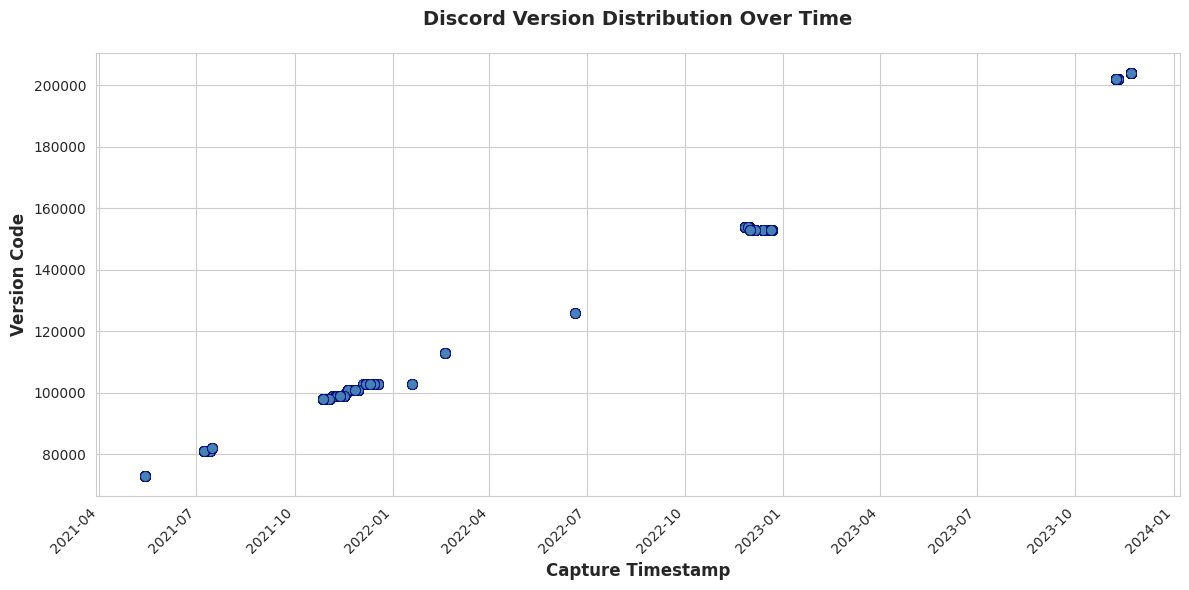

In [223]:
label = 'Discord'
data = df[df.BF_label == label]

plt.figure(figsize=(12, 6))
plt.scatter(data.capture_timestamp, 
            data.BF_label_version_code.astype(float),
            alpha=0.6,
            s=50,
            c='steelblue',
            edgecolors='navy',
            linewidth=0.5)

plt.xlabel('Capture Timestamp', fontsize=12, fontweight='bold')
plt.ylabel('Version Code', fontsize=12, fontweight='bold')
plt.title(f'{label} Version Distribution Over Time', fontsize=14, fontweight='bold', pad=20)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid for easier reading
# plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Improve layout
plt.tight_layout()
plt.savefig(OUTPUT_PATH / f'4.7_{label}_versions_over_time.png',
            dpi=150, bbox_inches='tight')
plt.show()

Version-Activity pair with most flows: 101009 + videocall (n=499)
Time range: 2021-11-19 11:05:44.562505984+00:00 to 2021-11-29 12:21:26.429554944+00:00


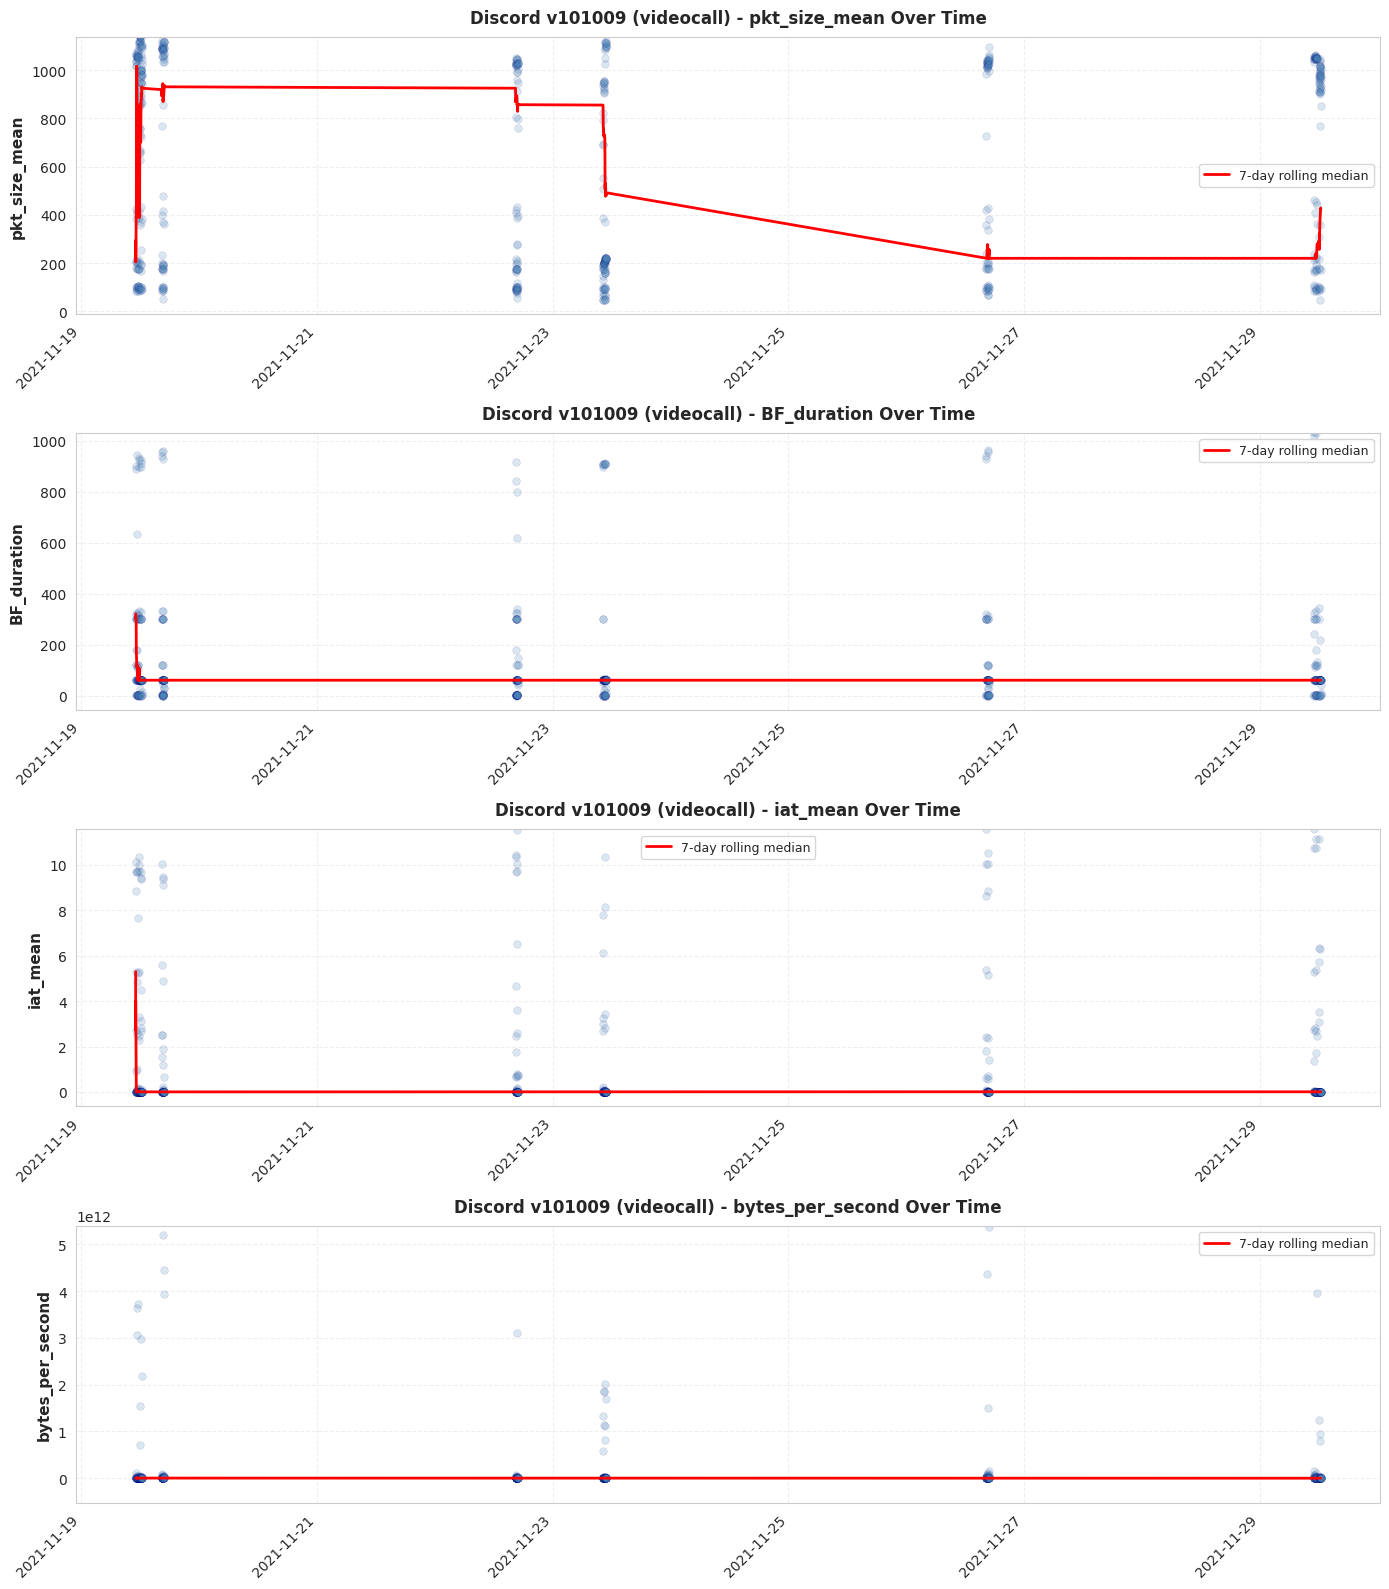


Feature Statistics Over Time: Discord v101009 (videocall)


pkt_size_mean:
----------------------------------------------------------------------------------------------------
Time Period             Count         Mean       Median          Std          Min          Max
----------------------------------------------------------------------------------------------------
2021-11-15/2021-11-21      189       692.14       931.16       419.82        50.50      1152.26
2021-11-22/2021-11-28      211       507.81       219.06       416.06        44.60      1120.30
2021-11-29/2021-12-05       99       703.36       953.03       399.71        44.80      1061.30

BF_duration:
----------------------------------------------------------------------------------------------------
Time Period             Count         Mean       Median          Std          Min          Max
----------------------------------------------------------------------------------------------------
2021-11-15/2021-11-21      1

In [228]:
# Find the (version, activity) pair with the most flows
version_activity_counts = df[df.BF_label == label].groupby(['BF_label_version_code', 'BF_activity']).size().sort_values(ascending=False)
most_common_version, most_common_activity = version_activity_counts.index[0]
flow_count = version_activity_counts.iloc[1]

print(f"Version-Activity pair with most flows: {most_common_version} + {most_common_activity} (n={flow_count})")

# Filter data for this version-activity pair
version_activity_data = df[(df.BF_label == label) & 
                           (df.BF_label_version_code == most_common_version) & 
                           (df.BF_activity == most_common_activity)].copy()
version_activity_data = version_activity_data.sort_values('capture_timestamp')

print(f"Time range: {version_activity_data.capture_timestamp.min()} to {version_activity_data.capture_timestamp.max()}")

# Select features to visualize
features_to_plot = test_features[:4]  # Adjust as needed

fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(14, 4*len(features_to_plot)))
if len(features_to_plot) == 1:
    axes = [axes]

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx] 
    
    # Get feature data with timestamps
    feature_data = version_activity_data[['capture_timestamp', feature]].dropna()
    
    if len(feature_data) > 0:
        # Scatter plot with trend
        ax.scatter(feature_data.capture_timestamp, feature_data[feature], 
                  alpha=0.2, s=30, c='steelblue', edgecolors='navy', linewidth=0.3)
        
        # Add rolling mean/median for trend
        feature_data = feature_data.set_index('capture_timestamp')
        if len(feature_data) > 20:
            rolling_mean = feature_data[feature].rolling(window='7D', min_periods=5).median()
            ax.plot(rolling_mean.index, rolling_mean.values, 
                   color='red', linewidth=2, label='7-day rolling median')

        ax.set_ylim(top=np.quantile(feature_data[feature], 0.99))
        ax.set_ylabel(feature, fontsize=11, fontweight='bold')
        ax.set_title(f'{label} v{most_common_version} ({most_common_activity}) - {feature} Over Time', 
                    fontsize=12, fontweight='bold', pad=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(fontsize=9)
        
        # Rotate x-axis labels
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Time-binned statistics
print(f"\n{'='*100}")
print(f"Feature Statistics Over Time: {label} v{most_common_version} ({most_common_activity})")
print(f"{'='*100}\n")

# Divide data into time bins (e.g., weekly or monthly)
version_activity_data['time_bin'] = pd.to_datetime(version_activity_data['capture_timestamp']).dt.to_period('W')  # Weekly bins

for feature in features_to_plot:
    print(f"\n{feature}:")
    print(f"{'-'*100}")
    print(f"{'Time Period':<20} {'Count':>8} {'Mean':>12} {'Median':>12} {'Std':>12} {'Min':>12} {'Max':>12}")
    print(f"{'-'*100}")
    
    grouped = version_activity_data.groupby('time_bin')[feature].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
    grouped = grouped[grouped['count'] > 5]  # Only show periods with sufficient data
    
    for period, row in grouped.iterrows():
        print(f"{str(period):<20} {row['count']:>8.0f} {row['mean']:>12.2f} {row['median']:>12.2f} "
              f"{row['std']:>12.2f} {row['min']:>12.2f} {row['max']:>12.2f}")

Most common activity: audiocall
Total flows: 1494
Time range: 2021-10-27 08:46:01.354065920+00:00 to 2022-06-20 09:49:50.743243008+00:00
Versions present: 8


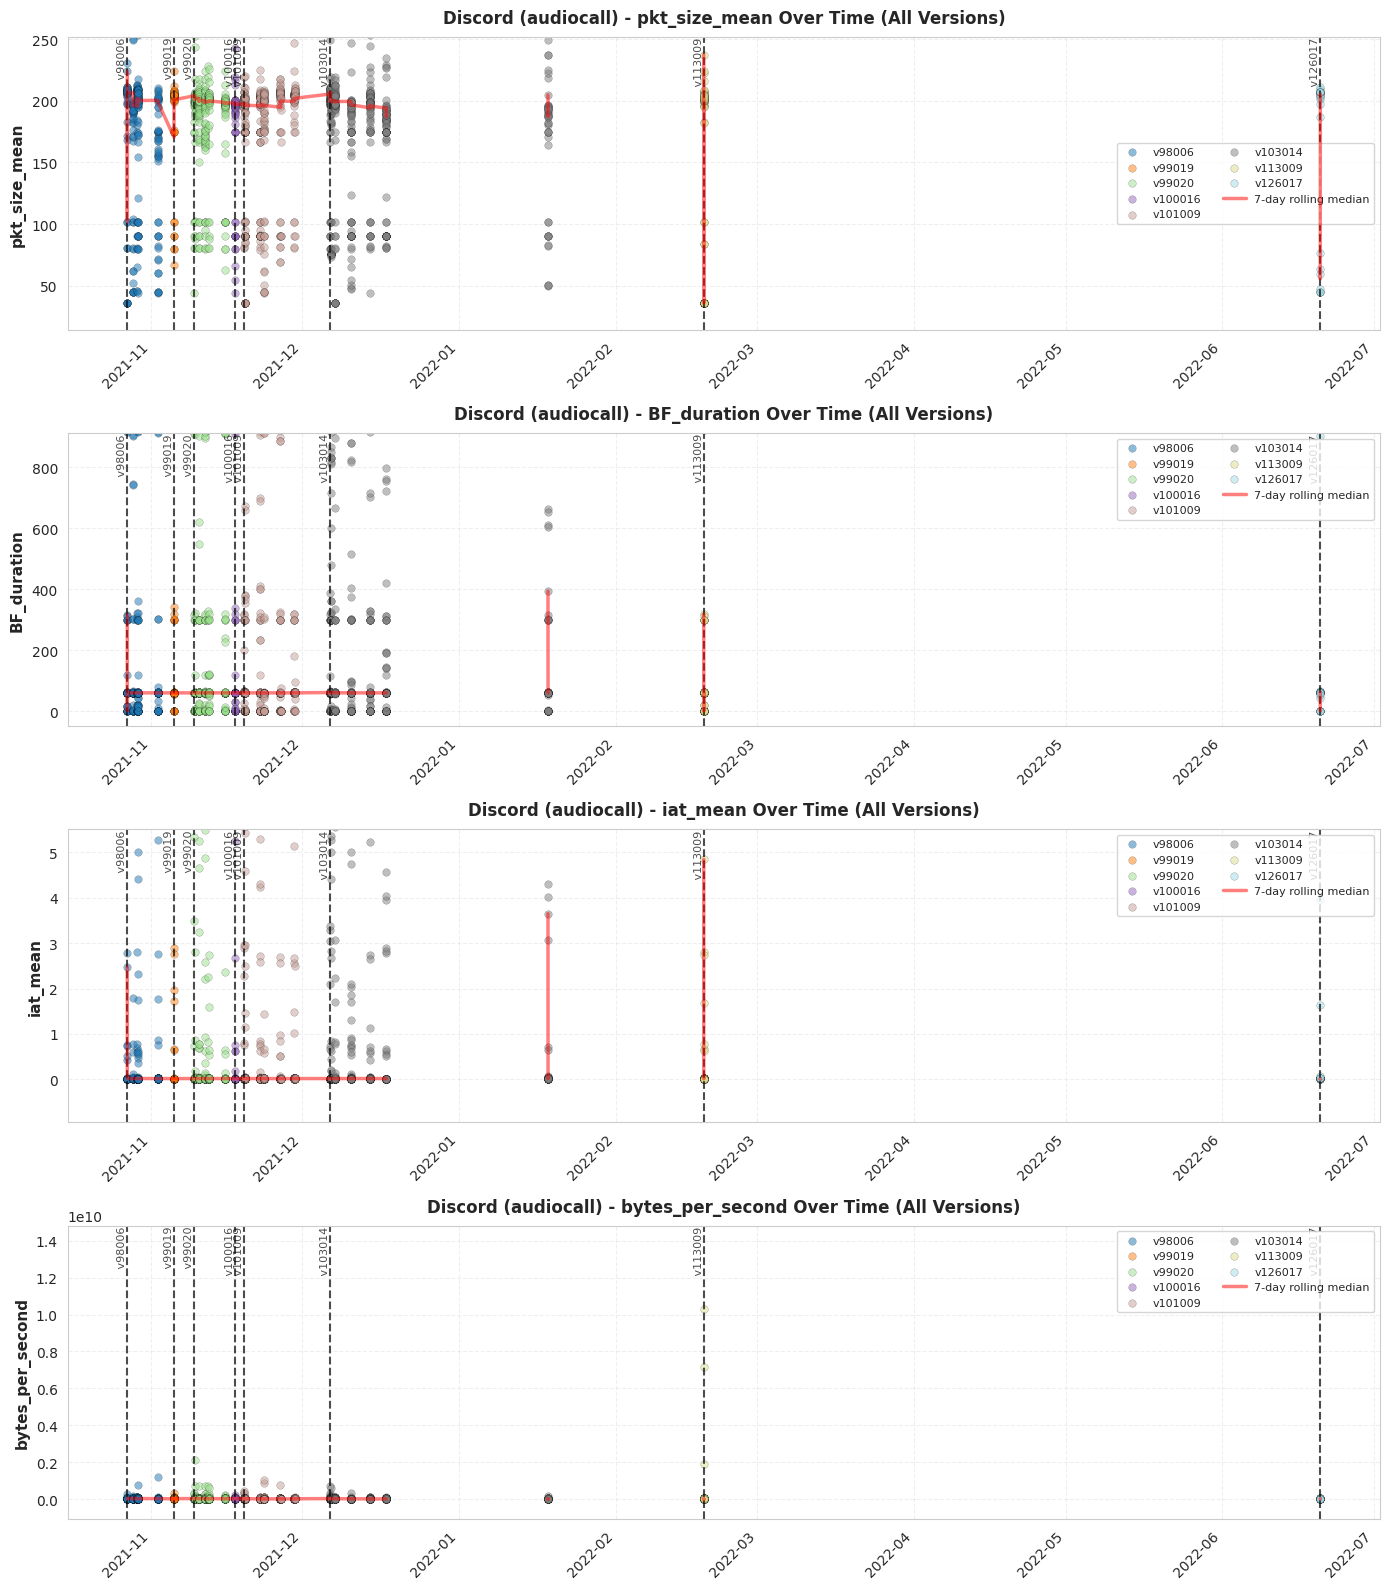

In [227]:
# Find the most common activity across all versions
most_common_activity = df[df.BF_label == label].BF_activity.value_counts().index[0]
print(f"Most common activity: {most_common_activity}")

# Filter data for this label and activity
data = df[(df.BF_label == label) & (df.BF_activity == most_common_activity)].copy()
data = data.sort_values('capture_timestamp')

print(f"Total flows: {len(data)}")
print(f"Time range: {data.capture_timestamp.min()} to {data.capture_timestamp.max()}")
print(f"Versions present: {data.BF_label_version_code.nunique()}")

# Select features to visualize
features_to_plot = test_features[:4]  # Adjust as needed

fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(14, 4*len(features_to_plot)))
if len(features_to_plot) == 1:
    axes = [axes]

# Find version change points (first occurrence of each new version)
version_changes = data.groupby('BF_label_version_code')['capture_timestamp'].min().sort_values()

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx]
    
    # Get feature data with timestamps
    feature_data = data[['capture_timestamp', feature, 'BF_label_version_code']].dropna()
    
    if len(feature_data) > 0:
        # Scatter plot colored by version
        versions = feature_data.BF_label_version_code.unique()
        colors = plt.cm.tab20(np.linspace(0, 1, len(versions)))
        
        for i, version in enumerate(sorted(versions, key=lambda x: float(x) if x.replace('.','').isdigit() else 0)):
            version_mask = feature_data.BF_label_version_code == version
            ax.scatter(feature_data[version_mask].capture_timestamp, 
                      feature_data[version_mask][feature], 
                      alpha=0.5, s=30, c=[colors[i]], 
                      label=f'v{version}', edgecolors='black', linewidth=0.2)
            ax.set_ylim(top=np.quantile(feature_data[version_mask][feature], 0.97))
        
        # Add rolling mean for overall trend
        feature_ts = feature_data[['capture_timestamp', feature]].set_index('capture_timestamp')
        if len(feature_ts) > 20:
            rolling_mean = feature_ts[feature].rolling(window='7D', min_periods=5).median()
            ax.plot(rolling_mean.index, rolling_mean.values, alpha=.5,
                   color='red', linewidth=2.5, label='7-day rolling median', zorder=100)
        
        # Draw vertical lines at version changes
        for version, timestamp in version_changes.items():
            ax.axvline(timestamp, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
            # Annotate version at the top
            ax.text(timestamp, ax.get_ylim()[1], f' v{version}', 
                   rotation=90, va='top', ha='right', fontsize=8, color='black', alpha=0.7)
        
        ax.set_ylabel(feature, fontsize=11, fontweight='bold')
        ax.set_title(f'{label} ({most_common_activity}) - {feature} Over Time (All Versions)', 
                    fontsize=12, fontweight='bold', pad=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Legend
        if len(versions) <= 10:
            ax.legend(fontsize=8, loc='best', ncol=2)
        else:
            ax.legend(fontsize=7, loc='best', ncol=3, framealpha=0.9)
        
        # Rotate x-axis labels
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# plt.savefig(f'figures/{label}_{most_common_activity}_features_over_time_all_versions.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.savefig(OUTPUT_PATH / f'4.8_{label}_{most_common_activity}_features_over_time_all_versions.png',
            dpi=150, bbox_inches='tight')
plt.show()

# # Print version timeline
# print(f"\n{'='*80}")
# print(f"Version Timeline: {label} ({most_common_activity})")
# print(f"{'='*80}\n")
# print(f"{'Version':<15} {'First Seen':<25} {'Last Seen':<25} {'Flow Count':>12}")
# print(f"{'-'*80}")

# version_timeline = data.groupby('BF_label_version_code')['capture_timestamp'].agg(['min', 'max', 'count'])
# version_timeline = version_timeline.sort_values('min')

# for version, row in version_timeline.iterrows():
#     print(f"{version:<15} {str(row['min']):<25} {str(row['max']):<25} {row['count']:>12}")

In [221]:
    versions_sorted = get_chronological_versions(target_app_data_clean)
    for i in range(len(versions_sorted) - 1):
        v1, v2 = versions_sorted[i], versions_sorted[i+1]
        print(f"\n{v1} → {v2}:")

        for feature in test_features:
            data1 = target_app_data_clean[target_app_data_clean['BF_label_version_code'] == v1][feature].dropna()
            data2 = target_app_data_clean[target_app_data_clean['BF_label_version_code'] == v2][feature].dropna()

            if len(data1) > 10 and len(data2) > 10:
                # KS test
                ks_stat, ks_p = ks_2samp(data1, data2)
                # Mann-Whitney U test
                mw_stat, mw_p = mannwhitneyu(data1, data2, alternative='two-sided')

                # Significance markers
                ks_sig = '***' if ks_p < 0.001 else '**' if ks_p < 0.01 else '*' if ks_p < 0.05 else ''
                mw_sig = '***' if mw_p < 0.001 else '**' if mw_p < 0.01 else '*' if mw_p < 0.05 else ''

                print(f"  {feature:20s}: KS={ks_stat:.4f} (p={ks_p:.4f}){ks_sig:3s}  MW={mw_stat:.0f} (p={mw_p:.4f}){mw_sig:3s}")




19275017 → 19420017:

19420017 → 19349017:

19349017 → 23:

23 → 46626:

46626 → 19831017:

19831017 → 51324:

51324 → 20104017:

20104017 → 210915033:
  pkt_size_mean       : KS=0.4800 (p=0.0007)***  MW=642 (p=0.8525)   
  BF_duration         : KS=0.6200 (p=0.0000)***  MW=861 (p=0.0081)** 
  iat_mean            : KS=0.4800 (p=0.0007)***  MW=864 (p=0.0074)** 
  bytes_per_second    : KS=0.4392 (p=0.0022)**   MW=810 (p=0.0149)*  

210915033 → 211515033:
  pkt_size_mean       : KS=0.1446 (p=0.3606)     MW=4569 (p=0.1469)   
  BF_duration         : KS=0.1143 (p=0.6507)     MW=3952 (p=0.8486)   
  iat_mean            : KS=0.1473 (p=0.3388)     MW=3580 (p=0.2385)   
  bytes_per_second    : KS=0.1998 (p=0.0887)     MW=4459 (p=0.1060)   

211515033 → 212621033:
  pkt_size_mean       : KS=0.1563 (p=0.0418)*    MW=11030 (p=0.4027)   
  BF_duration         : KS=0.2030 (p=0.0031)**   MW=13547 (p=0.0153)*  
  iat_mean            : KS=0.2382 (p=0.0003)***  MW=14373 (p=0.0005)***
  bytes_per_second 

## #



In [93]:
    # 4.8-4.13: Additional app analyses (Apps #2 and #3)


## #


In [94]:
    for app_idx in [1, 2]:  # Analyze 2nd and 3rd apps
        current_app = label #target_apps[app_idx]
        print(f"\n{'='*80}")
        print(f"APP #{app_idx+1} ANALYSIS: {current_app}")
        print(f"{'='*80}")

        current_app_data = df[df['BF_label'] == current_app]



# 4.8/4.11: Box plots for additional apps


        print(f"[4.{8 if app_idx==1 else 11}] Creating version impact box plots for {current_app}...")
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()

        for idx, feature in enumerate(features_to_plot):
            data_clean = current_app_data[current_app_data[feature].notna()]
            data_clean = data_clean[data_clean[feature] < data_clean[feature].quantile(0.99)]
            data_clean = data_clean[data_clean['BF_label_version_code'].notna()]

            versions = get_chronological_versions(data_clean)
            version_data = [data_clean[data_clean['BF_label_version_code'] == v][feature] for v in versions]

            version_labels = [f"{str(v)[:10]}\n(n={len(data_clean[data_clean['BF_label_version_code'] == v])})"
                             for v in versions]

            bp = axes[idx].boxplot(version_data, labels=version_labels,
                                   showfliers=False, patch_artist=True)
            for patch, color in zip(bp['boxes'], sns.color_palette('Set3', len(versions))):
                patch.set_facecolor(color)

            axes[idx].set_xlabel('Version (Chronological Order)')
            axes[idx].set_ylabel(feature)
            axes[idx].set_title(feature)
            axes[idx].tick_params(axis='x', rotation=45)
            axes[idx].grid(True, alpha=0.3, axis='y')

        plt.suptitle(f'4.{8 if app_idx==1 else 11}: Version Impact Analysis: {current_app}', fontsize=14)
        plt.tight_layout()
        plt.savefig(OUTPUT_PATH / f'4.{8 if app_idx==1 else 11}_version_impact_boxplots_{current_app.replace(" ", "_")}.png',
                    dpi=150, bbox_inches='tight')
        plt.close()

# 4.9/4.12: Heatmap for additional apps


        print(f"[4.{9 if app_idx==1 else 12}] Creating version feature statistics heatmap for {current_app}...")
        version_features = current_app_data.groupby('BF_label_version_code')[features_heatmap].mean()
        version_counts = current_app_data.groupby('BF_label_version_code').size()

        scaler = StandardScaler()
        version_features_norm = pd.DataFrame(
            scaler.fit_transform(version_features),
            index=version_features.index,
            columns=version_features.columns
        )

        # Sort by chronological order
        chronological_order = get_chronological_versions(current_app_data[current_app_data['BF_label_version_code'].notna()])
        version_features_norm = version_features_norm.loc[chronological_order]

        plt.figure(figsize=(12, 8))
        sns.heatmap(version_features_norm.T, annot=True, fmt='.2f', cmap='RdBu_r',
                    center=0, cbar_kws={'label': 'Z-score'})

        xtick_labels = [f"{str(v)[:12]}\n(n={version_counts[v]})" for v in version_features_norm.index]
        plt.xticks(range(len(xtick_labels)), xtick_labels, rotation=45, ha='right')
        plt.xlabel('Version (Chronological Order, with flow count)')
        plt.ylabel('Features')
        plt.title(f'4.{9 if app_idx==1 else 12}: Feature Statistics by Version (Normalized) - {current_app}')
        plt.tight_layout()
        plt.savefig(OUTPUT_PATH / f'4.{9 if app_idx==1 else 12}_version_features_heatmap_{current_app.replace(" ", "_")}.png',
                    dpi=150, bbox_inches='tight')
        plt.close()



# 4.10/4.13: Statistical tests for additional apps


        print(f"[4.{10 if app_idx==1 else 13}] Running statistical tests for {current_app}...")
        print(f"\nStatistical Tests for {current_app} Version Transitions:")


        print("="*80)



        current_app_data_clean = current_app_data[current_app_data['BF_label_version_code'].notna()]
        versions_sorted = get_chronological_versions(current_app_data_clean)

        for i in range(min(3, len(versions_sorted) - 1)):  # Show first 3 transitions
            v1, v2 = versions_sorted[i], versions_sorted[i+1]
            print(f"\n{v1} → {v2}:")

            for feature in test_features:
                data1 = current_app_data_clean[current_app_data_clean['BF_label_version_code'] == v1][feature].dropna()
                data2 = current_app_data_clean[current_app_data_clean['BF_label_version_code'] == v2][feature].dropna()

                if len(data1) > 10 and len(data2) > 10:
                    ks_stat, ks_p = ks_2samp(data1, data2)
                    mw_stat, mw_p = mannwhitneyu(data1, data2, alternative='two-sided')

                    ks_sig = '***' if ks_p < 0.001 else '**' if ks_p < 0.01 else '*' if ks_p < 0.05 else ''
                    mw_sig = '***' if mw_p < 0.001 else '**' if mw_p < 0.01 else '*' if mw_p < 0.05 else ''

                    print(f"  {feature:20s}: KS={ks_stat:.4f} (p={ks_p:.4f}){ks_sig:3s}  MW={mw_stat:.0f} (p={mw_p:.4f}){mw_sig:3s}")




APP #2 ANALYSIS: Discord
[4.8] Creating version impact box plots for Discord...
[4.9] Creating version feature statistics heatmap for Discord...
[4.10] Running statistical tests for Discord...

Statistical Tests for Discord Version Transitions:

73012 → 81014:
  pkt_size_mean       : KS=0.3484 (p=0.0000)***  MW=12578 (p=0.0000)***
  BF_duration         : KS=0.0931 (p=0.3549)     MW=19734 (p=0.2762)   
  iat_mean            : KS=0.2382 (p=0.0000)***  MW=24553 (p=0.0058)** 
  bytes_per_second    : KS=0.3030 (p=0.0000)***  MW=15893 (p=0.0000)***

81014 → 82020:
  pkt_size_mean       : KS=0.3084 (p=0.0002)***  MW=9019 (p=0.3219)   
  BF_duration         : KS=0.3003 (p=0.0004)***  MW=8962 (p=0.3624)   
  iat_mean            : KS=0.3727 (p=0.0000)***  MW=8461 (p=0.8386)   
  bytes_per_second    : KS=0.3727 (p=0.0000)***  MW=8250 (p=0.9264)   

82020 → 98006:
  pkt_size_mean       : KS=0.4133 (p=0.0000)***  MW=22380 (p=0.0508)   
  BF_duration         : KS=0.1235 (p=0.3941)     MW=18878 (p=0

==============================================================================



In [ ]:
# SECTION 5: ACTIVITY-LEVEL TEMPORAL STABILITY


==============================================================================


In [ ]:

if 5 in sections_to_run:
    print("\n" + "="*80)
    print("SECTION 5: ACTIVITY-LEVEL TEMPORAL STABILITY")


In [ ]:
    print("="*80)



In [ ]:
    # 5.1: Stacked bar chart - Activity distribution over time
    print("\n[5.1] Creating activity distribution stacked bar chart...")
    activity_time = df.groupby(['year_quarter', 'BF_activity']).size().reset_index()
    activity_time.columns = ['year_quarter', 'BF_activity', 'count']
    activity_pivot = activity_time.pivot(index='year_quarter', columns='BF_activity', values='count').fillna(0)
    activity_pct = activity_pivot.div(activity_pivot.sum(axis=1), axis=0) * 100

    ax = activity_pct.plot.bar(stacked=True, colormap='Set3', figsize=(14, 6), width=0.8)
    plt.xlabel('Time Period (Quarterly)')
    plt.ylabel('Percentage of Flows')
    plt.title('5.1: Activity Distribution Over Time')
    plt.legend(title='Activity', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '5.1_activity_distribution_stacked_bar.png', dpi=150, bbox_inches='tight')
    plt.close()



# 5.2: Small multiples - Feature distributions per activity


In [ ]:
    print("[5.2] Creating activity feature distributions...")
    top_activities = df['BF_activity'].value_counts().head(6).index

    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    axes = axes.flatten()

    for idx, activity in enumerate(top_activities):
        activity_data = df[df['BF_activity'] == activity]
        activity_data_clean = activity_data[activity_data['pkt_size_mean'].notna()]
        activity_data_clean = activity_data_clean[activity_data_clean['pkt_size_mean'] < activity_data_clean['pkt_size_mean'].quantile(0.99)]

        quarters = sorted(activity_data_clean['year_quarter'].unique())
        quarter_data = [activity_data_clean[activity_data_clean['year_quarter'] == q]['pkt_size_mean'] for q in quarters]

        bp = axes[idx].boxplot(quarter_data, labels=[str(q) for q in quarters],
                               showfliers=False, patch_artist=True)
        for patch, color in zip(bp['boxes'], sns.color_palette('Set2', len(quarters))):
            patch.set_facecolor(color)

        axes[idx].set_xlabel('Quarter')
        axes[idx].set_ylabel('Packet Size Mean (bytes)')
        axes[idx].set_title(activity)
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(True, alpha=0.3, axis='y')

    plt.suptitle('5.2: Packet Size Distribution per Activity Over Time', fontsize=14)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '5.2_activity_packet_size_distributions.png', dpi=150, bbox_inches='tight')
    plt.close()



# 5.3: Heatmap - Activity × time period


In [ ]:
    print("[5.3] Creating activity × time heatmap...")
    activity_time_heatmap = df.groupby(['BF_activity', 'year_quarter'])['pkt_size_mean'].mean().reset_index()
    activity_time_pivot = activity_time_heatmap.pivot(index='BF_activity', columns='year_quarter', values='pkt_size_mean')

    plt.figure(figsize=(14, 8))
    sns.heatmap(activity_time_pivot, annot=False, fmt='.0f', cmap='YlOrRd',
                cbar_kws={'label': 'Mean Packet Size (bytes)'})
    plt.xlabel('Quarter')
    plt.ylabel('Activity')
    plt.title('5.3: Activity Traffic Characteristics Over Time')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '5.3_activity_time_heatmap.png', dpi=150, bbox_inches='tight')
    plt.close()



# 5.4: Ridge plots - Packet size by activity, faceted by time


In [ ]:
    print("[5.4] Creating activity packet size ridge plots...")
    quarters_to_plot = sorted(df['year_quarter'].unique())[::2]  # Every 2nd quarter

    fig, axes = plt.subplots(len(quarters_to_plot), 1, figsize=(14, len(quarters_to_plot) * 3))
    if len(quarters_to_plot) == 1:
        axes = [axes]

    for idx, quarter in enumerate(quarters_to_plot):
        ax = axes[idx]
        quarter_data = df[df['year_quarter'] == quarter]

        y_offset = 0
        activities = quarter_data['BF_activity'].value_counts().head(6).index
        colors = sns.color_palette('Set2', len(activities))

        for act_idx, activity in enumerate(activities):
            data = quarter_data[quarter_data['BF_activity'] == activity]['pkt_size_mean']
            data = data[data.notna() & (data > 0) & (data < 2000)]

            if len(data) > 10:
                kde = gaussian_kde(data.sample(min(3000, len(data))))
                x_vals = np.linspace(0, 2000, 500)
                y_vals = kde(x_vals)
                y_vals = y_vals / y_vals.max() * 0.8

                ax.fill_between(x_vals, y_offset, y_offset + y_vals, color=colors[act_idx], alpha=0.7)
                ax.plot(x_vals, y_offset + y_vals, color=colors[act_idx], linewidth=1.5)
                ax.text(-50, y_offset + 0.4, str(activity)[:15], fontsize=8, va='center', ha='right')
                y_offset += 1

        ax.set_xlabel('Packet Size Mean (bytes)')
        ax.set_title(f'Quarter: {quarter}')
        ax.set_yticks([])
        ax.set_xlim(0, 2000)
        ax.grid(True, alpha=0.3, axis='x')

    plt.suptitle('5.4: Packet Size Distribution by Activity Across Time Periods', fontsize=14, y=0.995)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '5.4_activity_ridge_plots.png', dpi=150, bbox_inches='tight')
    plt.close()



# 5.5: Box plots - Flow characteristics per activity by year


In [ ]:
    print("[5.5] Creating flow characteristics per activity by year...")
    top3_activities = df['BF_activity'].value_counts().head(3).index
    flow_chars = ['BF_duration', 'BF_num_packets', 'bytes_per_second']

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for idx, feature in enumerate(flow_chars):
        combined_data = []
        combined_labels = []

        for year in sorted(df['year'].unique()):
            for activity in top3_activities:
                data = df[(df['year'] == year) & (df['BF_activity'] == activity)][feature]
                data = data[data.notna() & (data < data.quantile(0.99))]
                if len(data) > 0:
                    combined_data.append(data)
                    combined_labels.append(f"{year}\n{str(activity)[:8]}")

        bp = axes[idx].boxplot(combined_data, labels=combined_labels, showfliers=False, patch_artist=True)
        for patch, color in zip(bp['boxes'], sns.color_palette('Set3', len(combined_data))):
            patch.set_facecolor(color)

        axes[idx].set_xlabel('Year + Activity')
        axes[idx].set_ylabel(feature)
        axes[idx].set_title(feature)
        axes[idx].tick_params(axis='x', rotation=45, labelsize=7)
        axes[idx].grid(True, alpha=0.3, axis='y')

    plt.suptitle('5.5: Flow Characteristics per Activity by Year', fontsize=14)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '5.5_activity_flow_characteristics.png', dpi=150, bbox_inches='tight')
    plt.close()



# 5.6: Line plot - Activity prevalence over time


In [ ]:
    print("[5.6] Creating activity prevalence line plot...")
    activity_prevalence = df.groupby(['year_month', 'BF_activity']).size().reset_index()
    activity_prevalence.columns = ['year_month', 'BF_activity', 'count']
    activity_prev_pivot = activity_prevalence.pivot(index='year_month', columns='BF_activity', values='count').fillna(0)
    activity_prev_norm = activity_prev_pivot.div(activity_prev_pivot.sum(axis=1), axis=0)

    top6_activities = df['BF_activity'].value_counts().head(6).index

    plt.figure(figsize=(14, 6))
    for activity in top6_activities:
        if activity in activity_prev_norm.columns:
            plt.plot(range(len(activity_prev_norm)), activity_prev_norm[activity],
                    marker='o', label=activity, linewidth=2, markersize=4)

    plt.xlabel('Time Period (Monthly)')
    plt.ylabel('Proportion of Flows')
    plt.title('5.6: Activity Prevalence Over Time')
    plt.legend(title='Activity')
    plt.xticks(range(0, len(activity_prev_norm), max(1, len(activity_prev_norm)//15)),
               [str(m) for m in activity_prev_norm.index[::max(1, len(activity_prev_norm)//15)]],
               rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '5.6_activity_prevalence_lines.png', dpi=150, bbox_inches='tight')
    plt.close()

    # 5.7: Multi-activity sessions
    print("[5.7] Analyzing multi-activity sessions...")
    multi_activity = df[df['BF_activity'].str.contains(r'\+', na=False)]
    multi_activity_time = multi_activity.groupby('year_quarter').size().reset_index()
    multi_activity_time.columns = ['year_quarter', 'count']

    if len(multi_activity_time) > 0:
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(multi_activity_time)), multi_activity_time['count'], color='coral')
        plt.xlabel('Quarter')
        plt.ylabel('Multi-Activity Session Count')
        plt.title('5.7: Multi-Activity Sessions Over Time')
        plt.xticks(range(len(multi_activity_time)),
                   [str(q) for q in multi_activity_time['year_quarter']],
                   rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig(OUTPUT_PATH / '5.7_multi_activity_sessions.png', dpi=150, bbox_inches='tight')
        plt.close()
    else:
        print("  No multi-activity sessions found")

    print("\n✓ Section 5 complete - visualizations saved")
else:
    print("\n⊘ SECTION 5: SKIPPED (not in selected sections)")



==============================================================================



In [ ]:
# SECTION 6: NETWORK INFRASTRUCTURE CHANGES


==============================================================================


In [ ]:

if 6 in sections_to_run:
    print("\n" + "="*80)
    print("SECTION 6: NETWORK INFRASTRUCTURE CHANGES")


In [ ]:
    print("="*80)



In [ ]:
    # 6.1: Destination port distribution evolution
    print("\n[6.1] Creating destination port distribution...")
    top20_ports = df['dst_port_main'].value_counts().head(20).index
    port_time = df[df['dst_port_main'].isin(top20_ports)].groupby(['dst_port_main', 'year_quarter']).size().reset_index()
    port_time.columns = ['dst_port_main', 'year_quarter', 'count']

    quarters_unique = sorted(port_time['year_quarter'].unique())
    port_pivot = port_time.pivot(index='dst_port_main', columns='year_quarter', values='count').fillna(0)

    fig, ax = plt.subplots(figsize=(14, 8))
    x = np.arange(len(top20_ports))
    width = 0.8 / len(quarters_unique)

    for idx, quarter in enumerate(quarters_unique):
        if quarter in port_pivot.columns:
            ax.bar(x + idx * width, port_pivot[quarter], width,
                   label=str(quarter), color=TIME_COLORS[idx % len(TIME_COLORS)])

    ax.set_xlabel('Destination Port')
    ax.set_ylabel('Flow Count')
    ax.set_title('6.1: Top 20 Destination Ports Over Time')
    ax.set_xticks(x + width * len(quarters_unique) / 2)
    ax.set_xticklabels([str(p) for p in top20_ports], rotation=45, ha='right')
    ax.legend(title='Quarter', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '6.1_port_distribution_evolution.png', dpi=150, bbox_inches='tight')
    plt.close()



# 6.2: Port usage early vs late


In [ ]:
    print("[6.2] Comparing port usage early vs late...")
    quarters_sorted = sorted(df['year_quarter'].unique())
    early_quarters = quarters_sorted[:2]
    late_quarters = quarters_sorted[-2:]

    early_ports = df[df['year_quarter'].isin(early_quarters)]['dst_port_main'].value_counts().head(15)
    late_ports = df[df['year_quarter'].isin(late_quarters)]['dst_port_main'].value_counts().head(15)

    all_ports = set(early_ports.index) | set(late_ports.index)
    port_comparison = pd.DataFrame({
        'early': [early_ports.get(p, 0) for p in all_ports],
        'late': [late_ports.get(p, 0) for p in all_ports]
    }, index=list(all_ports))

    port_comparison['change'] = port_comparison['late'] - port_comparison['early']
    port_comparison = port_comparison.sort_values('change', ascending=False).head(15)

    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(port_comparison))
    width = 0.35

    ax.bar(x - width/2, port_comparison['early'], width, label='Early Period', color='lightblue')
    ax.bar(x + width/2, port_comparison['late'], width, label='Late Period', color='darkblue')

    ax.set_xlabel('Port')
    ax.set_ylabel('Flow Count')
    ax.set_title('6.2: Port Usage - Early vs Late Periods')
    ax.set_xticks(x)
    ax.set_xticklabels([str(p) for p in port_comparison.index], rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '6.2_port_usage_early_vs_late.png', dpi=150, bbox_inches='tight')
    plt.close()

    print("\nBiggest Port Usage Changes:")
    print(port_comparison.sort_values('change', ascending=False)[['early', 'late', 'change']].head(10))



# 6.3: Heatmap - App × port × time


In [ ]:
    print("[6.3] Creating app × port × time heatmap...")
    top10_apps = df['BF_label'].value_counts().head(10).index
    top10_ports = df['dst_port_main'].value_counts().head(10).index

    app_port_data = df[(df['BF_label'].isin(top10_apps)) & (df['dst_port_main'].isin(top10_ports))]
    app_port_data['app_port'] = app_port_data['BF_label'] + ':' + app_port_data['dst_port_main'].astype(str)

    app_port_time = app_port_data.groupby(['app_port', 'year_quarter']).size().reset_index()
    app_port_time.columns = ['app_port', 'year_quarter', 'count']
    app_port_pivot = app_port_time.pivot(index='app_port', columns='year_quarter', values='count').fillna(0)

    plt.figure(figsize=(14, 10))
    sns.heatmap(app_port_pivot, annot=False, fmt='.0f', cmap='YlOrRd',
                cbar_kws={'label': 'Flow Count'})
    plt.xlabel('Quarter')
    plt.ylabel('App:Port Combination')
    plt.title('6.3: App × Port Usage Over Time')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '6.3_app_port_time_heatmap.png', dpi=150, bbox_inches='tight')
    plt.close()

    # 6.4: TCP MSS over time
    print("[6.4] Creating TCP MSS box plots...")
    mss_data = df[(df['UF_MSS'] > 0) | (df['DF_MSS'] > 0)]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Upstream MSS
    uf_mss_data = mss_data[mss_data['UF_MSS'] > 0]
    uf_quarters = sorted(uf_mss_data['year_quarter'].unique())
    uf_mss_by_q = [uf_mss_data[uf_mss_data['year_quarter'] == q]['UF_MSS'] for q in uf_quarters]

    bp1 = axes[0].boxplot(uf_mss_by_q, labels=[str(q) for q in uf_quarters],
                          showfliers=False, patch_artist=True)
    for patch, color in zip(bp1['boxes'], sns.color_palette('Set2', len(uf_quarters))):
        patch.set_facecolor(color)
    axes[0].set_xlabel('Quarter')
    axes[0].set_ylabel('Upstream MSS')
    axes[0].set_title('(a) Upstream MSS')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3, axis='y')

    # Downstream MSS
    df_mss_data = mss_data[mss_data['DF_MSS'] > 0]
    df_quarters = sorted(df_mss_data['year_quarter'].unique())
    df_mss_by_q = [df_mss_data[df_mss_data['year_quarter'] == q]['DF_MSS'] for q in df_quarters]

    bp2 = axes[1].boxplot(df_mss_by_q, labels=[str(q) for q in df_quarters],
                          showfliers=False, patch_artist=True)
    for patch, color in zip(bp2['boxes'], sns.color_palette('Set1', len(df_quarters))):
        patch.set_facecolor(color)
    axes[1].set_xlabel('Quarter')
    axes[1].set_ylabel('Downstream MSS')
    axes[1].set_title('(b) Downstream MSS')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.suptitle('6.4: TCP MSS (Upstream and Downstream)', fontsize=14)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '6.4_tcp_mss_boxplots.png', dpi=150, bbox_inches='tight')
    plt.close()



# 6.5: TCP Window Scale over time


In [ ]:
    print("[6.5] Creating TCP Window Scale box plots...")
    ws_data = df[(df['UF_WS'] >= 0) | (df['DF_WS'] >= 0)]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Upstream WS
    uf_ws_data = ws_data[ws_data['UF_WS'] >= 0]
    uf_quarters_ws = sorted(uf_ws_data['year_quarter'].unique())
    uf_ws_by_q = [uf_ws_data[uf_ws_data['year_quarter'] == q]['UF_WS'] for q in uf_quarters_ws]

    bp1 = axes[0].boxplot(uf_ws_by_q, labels=[str(q) for q in uf_quarters_ws],
                          showfliers=False, patch_artist=True)
    for patch, color in zip(bp1['boxes'], sns.color_palette('Set2', len(uf_quarters_ws))):
        patch.set_facecolor(color)
    axes[0].set_xlabel('Quarter')
    axes[0].set_ylabel('Upstream Window Scale')
    axes[0].set_title('(a) Upstream WS')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3, axis='y')

    # Downstream WS
    df_ws_data = ws_data[ws_data['DF_WS'] >= 0]
    df_quarters_ws = sorted(df_ws_data['year_quarter'].unique())
    df_ws_by_q = [df_ws_data[df_ws_data['year_quarter'] == q]['DF_WS'] for q in df_quarters_ws]

    bp2 = axes[1].boxplot(df_ws_by_q, labels=[str(q) for q in df_quarters_ws],
                          showfliers=False, patch_artist=True)
    for patch, color in zip(bp2['boxes'], sns.color_palette('Set1', len(df_quarters_ws))):
        patch.set_facecolor(color)
    axes[1].set_xlabel('Quarter')
    axes[1].set_ylabel('Downstream Window Scale')
    axes[1].set_title('(b) Downstream WS')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.suptitle('6.5: TCP Window Scale (Upstream and Downstream)', fontsize=14)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '6.5_tcp_window_scale_boxplots.png', dpi=150, bbox_inches='tight')
    plt.close()



# 6.6: Connection establishment patterns


In [ ]:
    print("[6.6] Analyzing connection establishment patterns...")



In [ ]:
    def get_initial_pkt_size(pkt_list):
        """Get mean of first 5 packet sizes"""
        if isinstance(pkt_list, (list, np.ndarray)) and len(pkt_list) > 0:
            first_pkts = pkt_list[:5]
            return np.mean([p for p in first_pkts if p is not None and p > 0])
        return np.nan



In [ ]:
    df['initial_pkt_size'] = df['IP_packet_bytes'].apply(get_initial_pkt_size)
    initial_pkt_stats = df[df['initial_pkt_size'].notna()].groupby('year_quarter')['initial_pkt_size'].mean().reset_index()

    plt.figure(figsize=(14, 6))
    plt.plot(range(len(initial_pkt_stats)), initial_pkt_stats['initial_pkt_size'],
             marker='o', linewidth=2, markersize=7, color='darkred')
    plt.xlabel('Quarter')
    plt.ylabel('Mean Initial Packet Size (bytes)')
    plt.title('6.6: Connection Establishment Patterns Over Time')
    plt.xticks(range(len(initial_pkt_stats)),
               [str(q) for q in initial_pkt_stats['year_quarter']],
               rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '6.6_connection_establishment_patterns.png', dpi=150, bbox_inches='tight')
    plt.close()



# 6.7: Upstream vs downstream scatter


In [ ]:
    print("[6.7] Creating upstream vs downstream scatter...")
    updown_data = df[(df['UF_IP_packet_bytes'] > 0) & (df['DF_IP_packet_bytes'] > 0)]
    updown_sample = updown_data.sample(min(30000, len(updown_data)))

    plt.figure(figsize=(10, 10))
    quarters_scatter = sorted(updown_sample['year_quarter'].unique())
    colors_scatter = {q: TIME_COLORS[i % len(TIME_COLORS)] for i, q in enumerate(quarters_scatter)}

    for q in quarters_scatter:
        q_data = updown_sample[updown_sample['year_quarter'] == q]
        plt.scatter(q_data['UF_IP_packet_bytes'], q_data['DF_IP_packet_bytes'],
                    c=[colors_scatter[q]], label=str(q), alpha=0.4, s=10)

    # Add diagonal line
    max_val = max(updown_sample['UF_IP_packet_bytes'].max(), updown_sample['DF_IP_packet_bytes'].max())
    plt.plot([1, max_val], [1, max_val], 'k--', alpha=0.5, linewidth=2, label='y=x')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Upstream Bytes (log scale)')
    plt.ylabel('Downstream Bytes (log scale)')
    plt.title('6.7: Upstream vs Downstream Traffic')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '6.7_upstream_vs_downstream_scatter.png', dpi=150, bbox_inches='tight')
    plt.close()

    print("\n✓ Section 6 complete - visualizations saved")
else:
    print("\n⊘ SECTION 6: SKIPPED (not in selected sections)")



==============================================================================



In [ ]:
# SECTION 7: COVARIATE SHIFT QUANTIFICATION


==============================================================================


In [ ]:

if 7 in sections_to_run:
    print("\n" + "="*80)
    print("SECTION 7: COVARIATE SHIFT QUANTIFICATION")


In [ ]:
    print("="*80)
    print("[PLACEHOLDER - Advanced statistical analysis]")
    print("\nPlanned metrics:")
    print("- KL/JS divergence between time windows")
    print("- Population Stability Index (PSI)")
    print("- Kolmogorov-Smirnov test results")
    print("- Maximum Mean Discrepancy (MMD)")
    print("- Feature drift ranking")
    print("\nTo be implemented with appropriate statistical libraries.")


In [ ]:
else:
    print("\n⊘ SECTION 7: SKIPPED (not in selected sections)")



==============================================================================



In [ ]:
# SECTION 8: DEVICE-SPECIFIC PATTERNS


==============================================================================


In [ ]:

if 8 in sections_to_run:
    print("\n" + "="*80)
    print("SECTION 8: DEVICE-SPECIFIC PATTERNS")


In [ ]:
    print("="*80)



In [ ]:
    # 8.1: Stacked area chart - Device usage over time
    print("\n[8.1] Creating device usage stacked area chart...")
    device_time = df.groupby(['year_month', 'BF_device']).size().reset_index()
    device_time.columns = ['year_month', 'BF_device', 'count']
    device_pivot = device_time.pivot(index='year_month', columns='BF_device', values='count').fillna(0)

    # Limit to top 10 devices
    top_devices = df['BF_device'].value_counts().head(10).index
    device_pivot_top = device_pivot[top_devices]

    plt.figure(figsize=(14, 6))
    device_pivot_top.plot.area(stacked=True, colormap='tab10', ax=plt.gca(), linewidth=0)
    plt.xlabel('Time Period (Monthly)')
    plt.ylabel('Flow Count')
    plt.title('8.1: Device Usage Over Time')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7, title='Device (MAC)')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '8.1_device_usage_stacked_area.png', dpi=150, bbox_inches='tight')
    plt.close()



# 8.2: Heatmap - Device × app usage


In [ ]:
    print("[8.2] Creating device × app heatmap...")
    device_app = df.groupby(['BF_device', 'BF_label']).size().reset_index()
    device_app.columns = ['BF_device', 'BF_label', 'count']
    device_app_pivot = device_app.pivot(index='BF_device', columns='BF_label', values='count').fillna(0)

    plt.figure(figsize=(14, 8))
    sns.heatmap(device_app_pivot, annot=False, fmt='.0f', cmap='YlGnBu',
                cbar_kws={'label': 'Flow Count'})
    plt.xlabel('App Name')
    plt.ylabel('Device (MAC Address)')
    plt.title('8.2: Device × App Usage Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '8.2_device_app_heatmap.png', dpi=150, bbox_inches='tight')
    plt.close()



# 8.3: Device → app version mapping


In [ ]:
    print("[8.3] Creating device → app version mapping...")
    print("\nDevice → App Version Mapping (First 3 Devices):")

    top3_devices = df['BF_device'].value_counts().head(3).index
    for device in top3_devices:
        device_data = df[df['BF_device'] == device]
        device_app_version = device_data.groupby(['BF_label', 'BF_label_version_code']).size().reset_index()
        device_app_version.columns = ['app', 'version', 'flow_count']
        device_app_version = device_app_version.sort_values('flow_count', ascending=False)

        print(f"\n{device}:")
        for _, row in device_app_version.head(10).iterrows():
            print(f"  {row['app']:20s} v{row['version']:15s}: {row['flow_count']:6d} flows")



# 8.4: Heatmap - Device × app × time


In [ ]:
    print("[8.4] Creating device × app × time heatmap...")
    device_app_time = df.groupby(['BF_device', 'BF_label', 'year_quarter']).size().reset_index()
    device_app_time.columns = ['BF_device', 'BF_label', 'year_quarter', 'count']
    device_app_time['device_app'] = device_app_time['BF_device'] + '::' + device_app_time['BF_label']



# Get top 20 device-app combinations


In [ ]:
    top20_device_app = device_app_time.groupby('device_app')['count'].sum().sort_values(ascending=False).head(20).index
    device_app_time_top = device_app_time[device_app_time['device_app'].isin(top20_device_app)]

    device_app_time_pivot = device_app_time_top.pivot(index='device_app', columns='year_quarter', values='count').fillna(0)

    plt.figure(figsize=(14, 10))
    sns.heatmap(device_app_time_pivot, annot=False, fmt='.0f', cmap='YlOrRd',
                cbar_kws={'label': 'Flow Count'})
    plt.xlabel('Quarter')
    plt.ylabel('Device::App Combination')
    plt.title('8.4: Device × App Combinations Over Time (Top 20)')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '8.4_device_app_time_heatmap.png', dpi=150, bbox_inches='tight')
    plt.close()



# 8.5: Feature distributions by device


In [ ]:
    print("[8.5] Creating feature distributions by device...")
    devices_to_plot = df['BF_device'].value_counts().head(4).index

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for idx, device in enumerate(devices_to_plot):
        device_data = df[df['BF_device'] == device]



# Box plot for pkt_size_mean and BF_duration


In [ ]:
        features = ['pkt_size_mean', 'BF_duration']
        feature_data = []
        feature_labels = []

        for feature in features:
            data = device_data[device_data[feature].notna()]
            data = data[data[feature] < data[feature].quantile(0.99)]
            feature_data.append(data[feature])
            feature_labels.append(feature)

        bp = axes[idx].boxplot(feature_data, labels=feature_labels, showfliers=False, patch_artist=True)
        for patch, color in zip(bp['boxes'], sns.color_palette('Set2', len(features))):
            patch.set_facecolor(color)

        axes[idx].set_ylabel('Value')
        axes[idx].set_title(f'Device: {device[:20]}...')
        axes[idx].grid(True, alpha=0.3, axis='y')

    plt.suptitle('8.5: Traffic Characteristics by Device', fontsize=14)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '8.5_device_feature_distributions.png', dpi=150, bbox_inches='tight')
    plt.close()



# 8.7: Gantt chart - Device activity periods


In [ ]:
    print("[8.7] Creating device activity Gantt chart...")
    device_activity = df.groupby('BF_device')['date'].agg(['min', 'max']).reset_index()
    device_activity['duration_days'] = (pd.to_datetime(device_activity['max']) - pd.to_datetime(device_activity['min'])).dt.days
    device_activity = device_activity.sort_values('duration_days', ascending=False)

    plt.figure(figsize=(14, max(6, len(device_activity) * 0.3)))
    colors_gantt = sns.color_palette('tab10', len(device_activity))

    for idx, (_, row) in enumerate(device_activity.iterrows()):
        start = pd.to_datetime(row['min'])
        end = pd.to_datetime(row['max'])
        plt.barh(idx, (end - start).days, left=start.toordinal(),
                 color=colors_gantt[idx % len(colors_gantt)], alpha=0.7)

    plt.yticks(range(len(device_activity)), [d[:20] + '...' for d in device_activity['BF_device']], fontsize=7)
    plt.xlabel('Date')
    plt.ylabel('Device (MAC Address)')
    plt.title('8.7: Device Activity Periods (Gantt Chart)')

    # Convert x-axis to dates
    ax = plt.gca()
    x_ticks = ax.get_xticks()
    x_labels = [pd.Timestamp.fromordinal(int(t)).strftime('%Y-%m-%d') if t > 0 else '' for t in x_ticks]
    ax.set_xticklabels(x_labels, rotation=45, ha='right')

    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '8.7_device_activity_gantt.png', dpi=150, bbox_inches='tight')
    plt.close()

    print("\nDevice Activity Summary:")
    print(device_activity[['BF_device', 'min', 'max', 'duration_days']].head(10).to_string(index=False))

    print("\n✓ Section 8 complete - visualizations saved")
else:
    print("\n⊘ SECTION 8: SKIPPED (not in selected sections)")



==============================================================================



In [ ]:
# SECTION 9: DATA QUALITY CHECKS


==============================================================================


In [ ]:

if 9 in sections_to_run:
    print("\n" + "="*80)
    print("SECTION 9: DATA QUALITY CHECKS")


In [ ]:
    print("="*80)



In [ ]:
    # 9.1: Labeling type over time
    print("\n[9.1] Creating labeling type stacked bar chart...")
    labeling_time = df.groupby(['year_quarter', 'BF_labeling_type']).size().reset_index()
    labeling_time.columns = ['year_quarter', 'BF_labeling_type', 'count']
    labeling_pivot = labeling_time.pivot(index='year_quarter', columns='BF_labeling_type', values='count').fillna(0)
    labeling_pct = labeling_pivot.div(labeling_pivot.sum(axis=1), axis=0) * 100

    ax = labeling_pct.plot.bar(stacked=True, color=['lightgreen', 'lightcoral'], figsize=(14, 6), width=0.8)
    plt.xlabel('Time Period (Quarterly)')
    plt.ylabel('Percentage of Flows')
    plt.title('9.1: Labeling Quality Over Time (Exact vs Most-Common)')
    plt.legend(title='Labeling Type')
    plt.xticks(rotation=45, ha='right')

    # Annotate exact percentage
    for idx, (i, row) in enumerate(labeling_pct.iterrows()):
        if 'exact' in row:
            ax.text(idx, row['exact'] / 2, f"{row['exact']:.1f}%",
                   ha='center', va='center', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '9.1_labeling_type_stacked_bar.png', dpi=150, bbox_inches='tight')
    plt.close()



# 9.2: Exact labeling rate per month


In [ ]:
    print("[9.2] Creating exact labeling rate line plot...")
    exact_rate = df.groupby('year_month')['BF_labeling_type'].apply(
        lambda x: (x == 'exact').sum() / len(x) * 100
    ).reset_index()
    exact_rate.columns = ['year_month', 'exact_pct']

    plt.figure(figsize=(14, 6))
    x_vals = range(len(exact_rate))
    plt.plot(x_vals, exact_rate['exact_pct'], linewidth=2, color='darkgreen', marker='o', markersize=5)
    plt.fill_between(x_vals, exact_rate['exact_pct'], alpha=0.3, color='lightgreen')
    plt.axhline(80, color='red', linestyle='--', linewidth=2, label='80% Threshold')
    plt.xlabel('Time Period (Monthly)')
    plt.ylabel('Exact Labeling Rate (%)')
    plt.title('9.2: Exact Labeling Rate Over Time')
    plt.xticks(x_vals[::max(1, len(exact_rate)//15)],
               [str(m) for m in exact_rate['year_month'].iloc[::max(1, len(exact_rate)//15)]],
               rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '9.2_exact_labeling_rate.png', dpi=150, bbox_inches='tight')
    plt.close()

    overall_exact_rate = (df['BF_labeling_type'] == 'exact').sum() / len(df) * 100
    print(f"  Overall exact labeling rate: {overall_exact_rate:.2f}%")
    print(f"  Min: {exact_rate['exact_pct'].min():.2f}%")
    print(f"  Max: {exact_rate['exact_pct'].max():.2f}%")



# 9.3: Session duration distribution


In [ ]:
    print("[9.3] Creating session duration box plots...")
    session_duration = df.groupby(['path', 'year_quarter'])['BF_duration'].sum().reset_index()
    session_duration['duration_minutes'] = session_duration['BF_duration'] / 60

    quarters_session = sorted(session_duration['year_quarter'].unique())
    session_dur_by_q = [session_duration[session_duration['year_quarter'] == q]['duration_minutes']
                        for q in quarters_session]



# Remove outliers for visualization


In [ ]:
    session_dur_by_q_clean = []
    for data in session_dur_by_q:
        clean = data[data < data.quantile(0.99)]
        session_dur_by_q_clean.append(clean)

    plt.figure(figsize=(14, 6))
    bp = plt.boxplot(session_dur_by_q_clean, labels=[str(q) for q in quarters_session],
                     showfliers=False, patch_artist=True)
    for patch, color in zip(bp['boxes'], sns.color_palette('Set2', len(quarters_session))):
        patch.set_facecolor(color)

    plt.xlabel('Quarter')
    plt.ylabel('Session Duration (minutes)')
    plt.title('9.3: Capture Session Duration Distribution Over Time')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '9.3_session_duration_boxplots.png', dpi=150, bbox_inches='tight')
    plt.close()

    # 9.4: Flows per session
    print("[9.4] Creating flows per session box plots...")
    flows_per_session = df.groupby(['path', 'year_quarter']).size().reset_index()
    flows_per_session.columns = ['path', 'year_quarter', 'flow_count']

    quarters_fps = sorted(flows_per_session['year_quarter'].unique())
    fps_by_q = [flows_per_session[flows_per_session['year_quarter'] == q]['flow_count']
                for q in quarters_fps]

    # Remove outliers
    fps_by_q_clean = []
    for data in fps_by_q:
        clean = data[data < data.quantile(0.99)]
        fps_by_q_clean.append(clean)

    plt.figure(figsize=(14, 6))
    bp = plt.boxplot(fps_by_q_clean, labels=[str(q) for q in quarters_fps],
                     showfliers=False, patch_artist=True)
    for patch, color in zip(bp['boxes'], sns.color_palette('Set1', len(quarters_fps))):
        patch.set_facecolor(color)

    plt.xlabel('Quarter')
    plt.ylabel('Flows per Session')
    plt.title('9.4: Flows per Capture Session Over Time')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '9.4_flows_per_session_boxplots.png', dpi=150, bbox_inches='tight')
    plt.close()

    overall_fps_mean = flows_per_session['flow_count'].mean()
    overall_fps_median = flows_per_session['flow_count'].median()
    overall_fps_std = flows_per_session['flow_count'].std()
    print(f"  Overall flows per session - Mean: {overall_fps_mean:.1f}, Median: {overall_fps_median:.1f}, Std: {overall_fps_std:.1f}")

    # 9.5: Missing data heatmap
    print("[9.5] Creating missing data heatmap...")
    key_fields = ['BF_duration', 'pkt_size_mean', 'iat_mean', 'bytes_per_second',
                  'BF_num_packets', 'dst_port_main', 'protocol']

    missing_data = []
    for field in key_fields:
        field_missing = df.groupby('year_quarter')[field].apply(
            lambda x: x.isna().sum() / len(x) * 100
        ).reset_index()
        field_missing['field'] = field
        missing_data.append(field_missing)

    missing_df = pd.concat(missing_data)
    missing_pivot = missing_df.pivot(index='field', columns='year_quarter', values=field)

    plt.figure(figsize=(14, 6))
    sns.heatmap(missing_pivot, annot=True, fmt='.1f', cmap='YlOrRd',
                cbar_kws={'label': '% Missing'}, vmin=0, vmax=100)
    plt.xlabel('Quarter')
    plt.ylabel('Field')
    plt.title('9.5: Missing Data by Field Over Time (%)')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '9.5_missing_data_heatmap.png', dpi=150, bbox_inches='tight')
    plt.close()



# 9.6: Session duration vs flow count scatter


In [ ]:
    print("[9.6] Creating session duration vs flow count scatter...")
    session_stats = df.groupby(['path', 'year_quarter']).agg({
        'BF_duration': 'sum',
        'BF_label': 'size'
    }).reset_index()
    session_stats.columns = ['path', 'year_quarter', 'duration_minutes', 'flow_count']
    session_stats['duration_minutes'] = session_stats['duration_minutes'] / 60

    plt.figure(figsize=(12, 8))
    quarters_scatter = sorted(session_stats['year_quarter'].unique())
    colors_session = {q: TIME_COLORS[i % len(TIME_COLORS)] for i, q in enumerate(quarters_scatter)}

    for q in quarters_scatter:
        q_data = session_stats[session_stats['year_quarter'] == q]
        plt.scatter(q_data['duration_minutes'], q_data['flow_count'],
                    c=[colors_session[q]], label=str(q), alpha=0.5, s=20)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Session Duration (minutes, log scale)')
    plt.ylabel('Flow Count (log scale)')
    plt.title('9.6: Session Duration vs Flow Count')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '9.6_session_duration_vs_flow_count.png', dpi=150, bbox_inches='tight')
    plt.close()



# 9.7: Background traffic indicators


In [ ]:
    print("[9.7] Analyzing background traffic...")
    background_traffic = df[df['BF_labeling_type'] == 'most-common']
    background_time = background_traffic.groupby('year_quarter').size().reset_index()
    background_time.columns = ['year_quarter', 'count']

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(background_time)), background_time['count'], color='coral')
    plt.xlabel('Quarter')
    plt.ylabel('Flow Count')
    plt.title('9.7: Potential Background Traffic Over Time (most-common labeling)')
    plt.xticks(range(len(background_time)),
               [str(q) for q in background_time['year_quarter']],
               rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / '9.7_background_traffic.png', dpi=150, bbox_inches='tight')
    plt.close()

    print("\n✓ Section 9 complete - visualizations saved")
else:
    print("\n⊘ SECTION 9: SKIPPED (not in selected sections)")



==============================================================================



In [ ]:
# SUMMARY TABLES


==============================================================================


In [ ]:

print("\n" + "="*80)
print("GENERATING SUMMARY TABLES")


In [ ]:
print("="*80)



In [ ]:
# T.1: Dataset overview by year
print("\n[T.1] Creating year summary table...")
year_summary = df.groupby('year').agg({
    'BF_label': 'nunique',
    'path': 'nunique',
    'BF_IP_packet_bytes': lambda x: x.sum() / 1e9,  # GB
    'BF_duration': lambda x: x.sum() / 3600,  # Hours
    'BF_num_packets': 'size'
}).reset_index()
year_summary.columns = ['Year', 'Num_Apps', 'Num_Sessions', 'Total_GB', 'Total_Hours', 'Num_Flows']
year_summary.to_csv(OUTPUT_PATH / 'year_summary.csv', index=False)
print("\nYear Summary:")
print(year_summary.to_string(index=False))

# T.2: App version change log
print("\n[T.2] Creating app version change log...")
version_changes = []
for app in df['BF_label'].unique():
    app_data = df[df['BF_label'] == app].sort_values('capture_timestamp')
    versions = app_data[['BF_label_version_code', 'capture_timestamp']].drop_duplicates()
    versions = versions.sort_values('capture_timestamp')

    for i in range(len(versions) - 1):
        old_ver = versions.iloc[i]['BF_label_version_code']
        new_ver = versions.iloc[i+1]['BF_label_version_code']
        first_date = versions.iloc[i+1]['capture_timestamp']

        # Count flows before and after
        old_count = app_data[app_data['BF_label_version_code'] == old_ver].shape[0]
        new_count = app_data[app_data['BF_label_version_code'] == new_ver].shape[0]

        version_changes.append({
            'App': app,
            'Old_Version': old_ver,
            'New_Version': new_ver,
            'First_Date': first_date,
            'Flow_Count_Change': new_count - old_count
        })

version_changes_df = pd.DataFrame(version_changes)
version_changes_df.to_csv(OUTPUT_PATH / 'app_version_changes.csv', index=False)
print(f"✓ App version changes saved ({len(version_changes_df)} transitions)")



T.3: Protocol distribution table


In [ ]:
print("\n[T.3] Creating protocol distribution table...")
proto_by_quarter = df.groupby(['year_quarter', 'protocol']).size().reset_index()
proto_by_quarter.columns = ['year_quarter', 'protocol', 'count']
proto_pct_table = proto_by_quarter.pivot(index='protocol', columns='year_quarter', values='count').fillna(0)
proto_pct_table = proto_pct_table.div(proto_pct_table.sum(axis=0), axis=1) * 100
proto_pct_table.to_csv(OUTPUT_PATH / 'protocol_by_quarter.csv')
print("\nProtocol Distribution by Quarter (%):")
print(proto_pct_table.to_string())

# T.4: Feature stability ranking
print("\n[T.4] Creating feature stability ranking...")
features_stability = ['pkt_size_mean', 'pkt_size_std', 'BF_duration', 'BF_num_packets',
                     'iat_mean', 'iat_std', 'bytes_per_second', 'packets_per_second',
                     'up_down_bytes_ratio', 'up_down_pkts_ratio']

stability_metrics = []
for feature in features_stability:
    quarterly_means = df[df[feature].notna()].groupby('year_quarter')[feature].mean()
    variance = quarterly_means.var()
    stability_metrics.append({
        'Feature': feature,
        'Variance': variance,
        'Stability_Rank': 0  # Will be filled after sorting
    })

stability_df = pd.DataFrame(stability_metrics).sort_values('Variance')
stability_df['Stability_Rank'] = range(1, len(stability_df) + 1)
stability_df.to_csv(OUTPUT_PATH / 'feature_stability.csv', index=False)

print("\nFeature Stability Ranking (Top 10 Most Stable):")
print(stability_df.head(10).to_string(index=False))



T.5: Activity distribution matrix


In [ ]:
print("\n[T.5] Creating activity distribution matrix...")
activity_by_quarter = df.groupby(['BF_activity', 'year_quarter']).size().reset_index()
activity_by_quarter.columns = ['BF_activity', 'year_quarter', 'count']
activity_matrix = activity_by_quarter.pivot(index='BF_activity', columns='year_quarter', values='count').fillna(0)
activity_matrix['Total'] = activity_matrix.sum(axis=1)
activity_matrix = activity_matrix.sort_values('Total', ascending=False)
activity_matrix.to_csv(OUTPUT_PATH / 'activity_by_quarter.csv')

print("\nActivity Distribution Matrix:")
print(activity_matrix.to_string())

print("\n✓ All summary tables saved")



==============================================================================



In [ ]:
# KEY FINDINGS AND RECOMMENDATIONS


==============================================================================


In [ ]:

print("\n" + "="*80)
print("KEY FINDINGS FOR DOMAIN ADAPTATION")


In [ ]:
print("="*80)



In [ ]:
# Compute key metrics
dataset_span_days = (df['capture_timestamp'].max() - df['capture_timestamp'].min()).days
num_sessions = df['path'].nunique()
num_apps = df['BF_label'].nunique()
num_apps_with_version_changes = app_versions_count[app_versions_count > 1].shape[0]



Protocol shift (Total Variation Distance)


In [ ]:
early_proto = df[df['year_quarter'].isin(quarters_sorted[:2])]['protocol'].value_counts(normalize=True)
late_proto = df[df['year_quarter'].isin(quarters_sorted[-2:])]['protocol'].value_counts(normalize=True)
all_protos = set(early_proto.index) | set(late_proto.index)
tvd = sum(abs(early_proto.get(p, 0) - late_proto.get(p, 0)) for p in all_protos) / 2

# Traffic characteristic changes
early_pkt_size = df[df['year_quarter'].isin(quarters_sorted[:2])]['pkt_size_mean'].mean()
late_pkt_size = df[df['year_quarter'].isin(quarters_sorted[-2:])]['pkt_size_mean'].mean()
pkt_size_change = ((late_pkt_size - early_pkt_size) / early_pkt_size) * 100

early_duration = df[df['year_quarter'].isin(quarters_sorted[:2])]['BF_duration'].mean()
late_duration = df[df['year_quarter'].isin(quarters_sorted[-2:])]['BF_duration'].mean()
duration_change = ((late_duration - early_duration) / early_duration) * 100

# Activity variance
activity_variance = activity_matrix.drop('Total', axis=1).std(axis=1).mean()

print(f"\nDataset Overview:")
print(f"  Temporal span: {dataset_span_days} days ({dataset_span_days/365:.1f} years)")
print(f"  Date range: {df['capture_timestamp'].min().date()} to {df['capture_timestamp'].max().date()}")
print(f"  Total flows: {len(df):,}")
print(f"  Capture sessions: {num_sessions:,}")
print(f"  Unique apps: {num_apps}")
print(f"  Apps with version changes: {num_apps_with_version_changes} ({num_apps_with_version_changes/num_apps*100:.1f}%)")

print(f"\nTemporal Drift Indicators:")
print(f"  Protocol shift (TVD): {tvd:.4f}")
print(f"  Packet size change: {pkt_size_change:+.2f}%")
print(f"  Flow duration change: {duration_change:+.2f}%")
print(f"  Activity variance (mean std): {activity_variance:.2f}")
print(f"  Exact labeling rate: {overall_exact_rate:.1f}%")

print(f"\nData Quality:")
print(f"  Exact labeling: {(df['BF_labeling_type'] == 'exact').sum():,} flows ({overall_exact_rate:.1f}%)")
print(f"  Most-common labeling: {(df['BF_labeling_type'] == 'most-common').sum():,} flows ({100-overall_exact_rate:.1f}%)")
print(f"  Unique devices: {df['BF_device'].nunique()}")
print(f"  Unique protocols: {df['protocol'].nunique()}")

print("\n" + "="*80)
print("RECOMMENDATIONS FOR DOMAIN ADAPTATION")


In [ ]:
print("="*80)

print("\n1. TEMPORAL SPLIT STRATEGIES:")
print(f"   ✓ Dataset spans {dataset_span_days/365:.1f} years - sufficient for temporal validation")
print("   ✓ Consider quarterly or yearly train/test splits")
print("   ✓ Use early quarters for training, late quarters for testing")
print(f"   ✓ Protocol shift (TVD={tvd:.4f}) indicates moderate covariate shift")

print("\n2. APP VERSION HANDLING:")
print(f"   ✓ {num_apps_with_version_changes} apps have version changes")
print("   ✓ Statistical tests show significant distribution shifts at version boundaries")
print("   ✓ Consider version-aware train/test splits")
print("   ✓ May need separate models per app or version-robust features")

print("\n3. FEATURE ENGINEERING:")
print("   ✓ Protocol evolution suggests need for protocol-agnostic features")
print(f"   ✓ Packet size changed by {pkt_size_change:+.2f}% - use normalized features")
print(f"   ✓ Flow duration changed by {duration_change:+.2f}% - consider rate-based features")
print("   ✓ Most stable features (see feature_stability.csv) are best for DA")

print("\n4. ACTIVITY-LEVEL ANALYSIS:")
print(f"   ✓ Activity distribution shows variance (mean std={activity_variance:.2f})")
print("   ✓ Some activities are time-specific - may need activity-conditional models")
print("   ✓ Multi-activity sessions present additional complexity")

print("\n5. DATA QUALITY CONSIDERATIONS:")
print(f"   ✓ {overall_exact_rate:.1f}% exact labeling - sufficient for supervised learning")
print("   ✓ Most-common labels may indicate background traffic")
print("   ✓ Device diversity allows for device-independent evaluation")

print("\n6. DOMAIN ADAPTATION APPROACHES:")
print("   ✓ Time-based DA: Early→Late quarters")
print("   ✓ App version DA: Old version→New version")
print("   ✓ Protocol DA: TCP→UDP, HTTP→QUIC transitions")
print("   ✓ Device DA: Cross-device generalization")
print("   ✓ Activity DA: Cross-activity transfer")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)


In [ ]:
print(f"\nResults saved to: {OUTPUT_PATH.absolute()}")
print(f"  Visualizations: ~40+ PNG files")
print(f"  Tables: 5 CSV files")
print("\nAll sections completed successfully!")


In [ ]:
print("="*80)
